# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- SOLV: Data doesn't exist for startDate = 1443499200, endDate = 1695787200
- VLTO: Data doesn't exist for startDate = 1443499200, endDate = 1695787200
- GEV: Data doesn't exist for startDate = 1443499200, endDate = 1695787200


adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483557   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684565   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334904   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478699   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[989155 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483557   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684565   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334904   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478699   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146751  4.488345   
           YUM       1500600.0          0.000002  36.057180  4.816569   
           ZBH       3610500.0          0.000099  31.893259  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623467  5.156108   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913563  
           AAL          NaN       NaN       NaN       NaN     279.420069  
           AAPL         NaN       NaN       NaN       NaN    7243.971820  
           ABBV         NaN       NaN       NaN       NaN     466.641901  
           ABT          NaN       NaN       NaN       NaN     411.369511  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188     117.651912  
           YUM     4.846536  4.876502  0.142547 -1.363696     184.291052  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.214922  5.273735  0.651515 -1.188279     256.861393  

[989155 rows x 14 columns]

<AxesSubplot:title={'center':'Garman Klass Volatility Over Time'}, xlabel='date'>

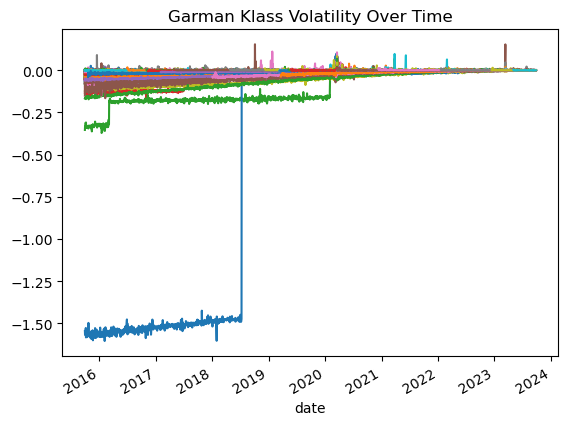

In [3]:
df['garman_klass_vol'].unstack().plot(title='Garman Klass Volatility Over Time', legend = False)


<AxesSubplot:title={'center':'RSI Over Time'}, xlabel='date'>

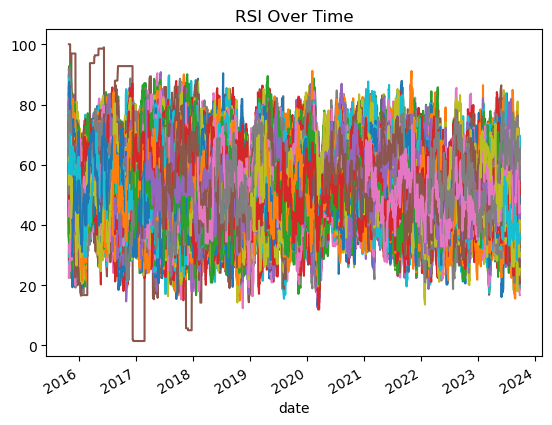

In [4]:
df['rsi'].unstack().plot(title='RSI Over Time', legend = False)

<AxesSubplot:title={'center':'ATR Over Time'}, xlabel='date'>

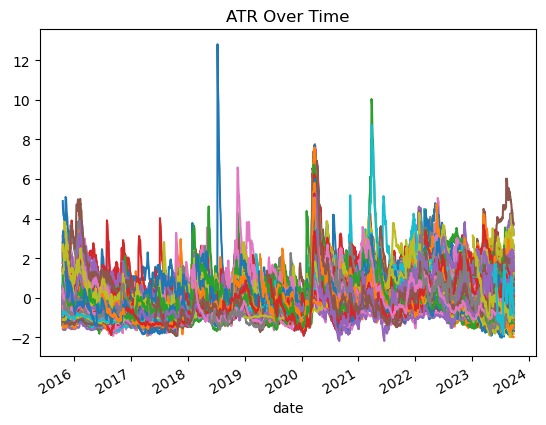

In [5]:
df['atr'].unstack().plot(title='ATR Over Time', legend = False)


<AxesSubplot:title={'center':'MACD Over Time'}, xlabel='date'>

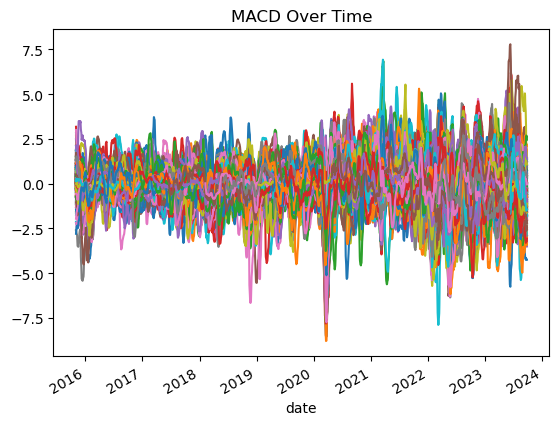

In [6]:
df['macd'].unstack().plot(title='MACD Over Time', legend = False)


In [7]:
df.columns

Index(['adj close', 'close', 'high', 'low', 'open', 'volume',
       'garman_klass_vol', 'rsi', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd',
       'dollar_volume'],
      dtype='object')

<AxesSubplot:title={'center':'Bollinger Bands for AAPL'}, xlabel='date'>

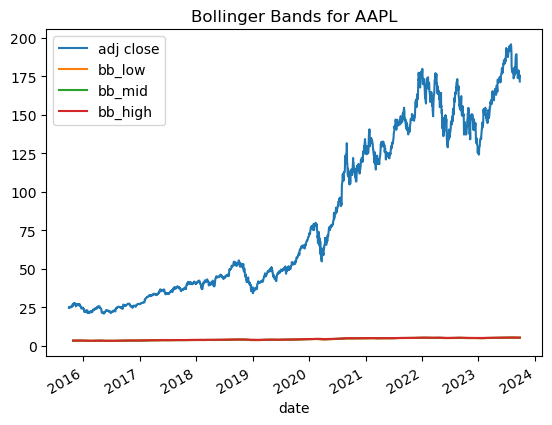

In [8]:
ticker = 'AAPL'  # Replace with the ticker of interest
df.xs(ticker, level='ticker')[['adj close', 'bb_low', 'bb_mid', 'bb_high']].plot(title=f'Bollinger Bands for {ticker}')


<AxesSubplot:title={'center':'Dollar Volume Over Time'}, xlabel='date'>

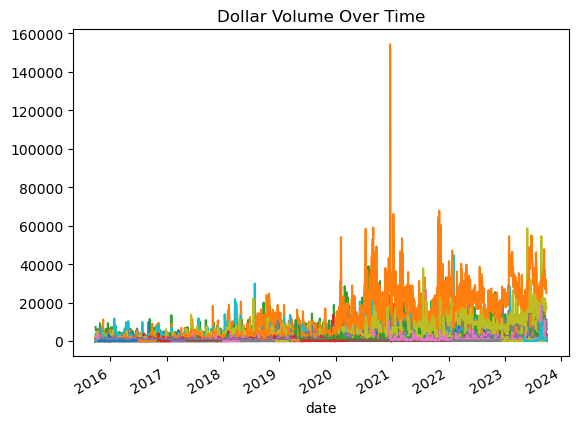

In [9]:
df['dollar_volume'].unstack().plot(title='Dollar Volume Over Time', legend = False)


## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [11]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          135.992826   39.023178 -1.033887  3.690888  3.545992   
           AAL        287.915792   39.429932  0.190822  3.827636  3.672028   
           AAPL      4029.441850   26.890560 -0.967900  3.369611  3.282983   
           ABBV       337.563929   40.393524 -0.526809  3.823191  3.726695   
           ABT        211.659048   38.293560 -1.064842  3.699763  3.656056   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.983159   78.671936 -1.028320  4.464683  4.374104   
           ABNB      1633.500725  132.279999 -1.006939  5.024801  4.857047   
           CEG        196.971016  108.026917 -0.436215  4.734007  4.653660   
           GEHC       212.275850   66.130219 -0.893478  4.270508  4.155436   
           KVUE       677.910277   20.218124 -0.899746  3.174263  3.024299   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.618440         -0.001992  0.567157  73.421516  
           AAL     3.749832         -0.000966 -0.418772  40.718986  
           AAPL    3.326297         -0.003209 -0.142790  55.537347  
           ABBV    3.774943         -0.059549  0.145676  49.376836  
           ABT     3.677909         -0.011216  0.335556  56.962508  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.419394         -0.000020 -1.534536  33.116246  
           ABNB    4.940924          0.000213 -0.037854  44.494127  
           CEG     4.693834          0.000171  0.366876  55.245485  
           GEHC    4.212972          0.000185 -1.116463  40.922336  
           KVUE    3.099281          0.000032 -1.435621  35.706337  

[46702 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [12]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-10-31 AAL      39.134323  0.402199  3.706314  3.604673  3.655494   
           AAPL     26.248026 -1.038688  3.353305  3.295542  3.324423   
           ABBV     40.245121 -0.893132  3.861774  3.753446  3.807610   
           ABT      34.293461 -1.035224  3.655580  3.554632  3.605106   
           ACN     103.569626 -0.996806  4.660617  4.637342  4.648980   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292953  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL            -0.000176  1.131595  62.203511  
           AAPL           -0.002384 -0.195978  49.891059  
           ABBV           -0.046691 -0.760593  27.477734  
           ABT            -0.007492 -0.650888  38.008835  
           ACN            -0.004643 -0.135456  53.823660  
...                             ...       ...        ...  
2023-09-30 WMT            -0.000011  0.399459  54.722560  
           XOM             0.000026  1.400623  59.440179  
           MRNA            0.000146 -0.376899  38.747314  
           UBER            0.000441 -0.133973  45.005268  
           ABNB            0.000213 -0.037854  44.494127  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [13]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534172  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.767776 -0.906642  3.689797  3.596048  3.642922   
           ABBV     67.491135  0.375557  4.289423  4.196702  4.243063   
           ABT      48.493370 -1.040044  3.939707  3.892568  3.916137   
           ACN     129.399750 -0.986514  4.882034  4.802675  4.842354   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.783062 -0.196381  4.023309  3.988367  4.005838   
           XOM     114.292953  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.018697  41.051803  -0.014108   
           AAPL           -0.000997 -0.039275  69.196704   0.096808   
           ABBV           -0.034008  0.473813  55.247809   0.022728   
           ABT            -0.005190  0.276133  53.844864   0.021276   
           ACN            -0.003925  0.352343  69.365517   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 WMT            -0.000011  0.399459  54.722560  -0.000676   
           XOM             0.000026  1.400623  59.440179   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   
           ABNB            0.000213 -0.037854  44.494127   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035229  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10340 rows x 14 columns]

In [14]:
import seaborn as sns

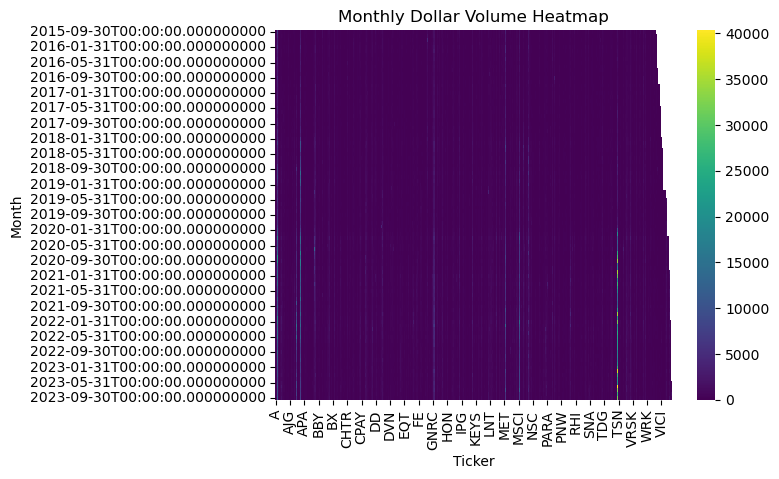

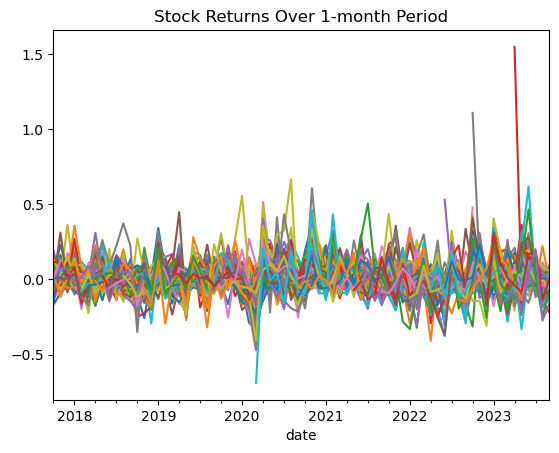

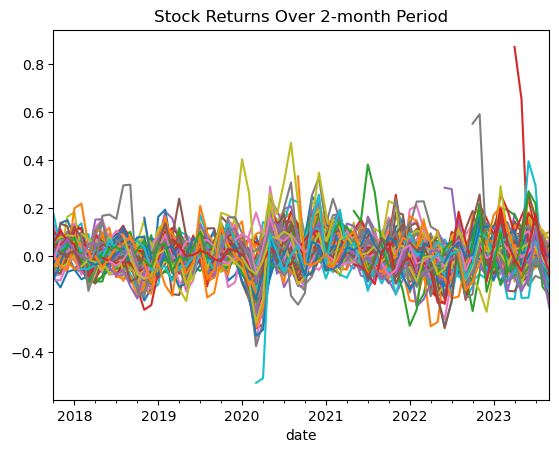

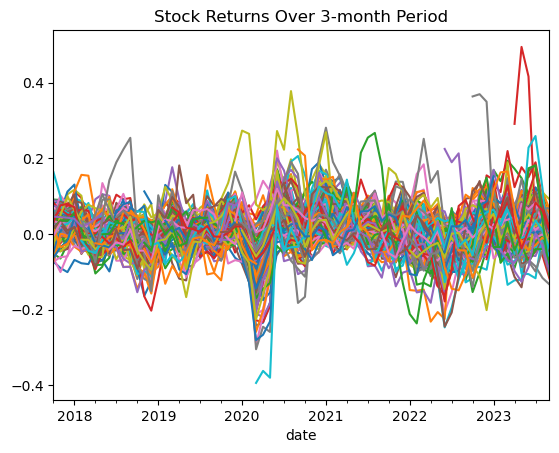

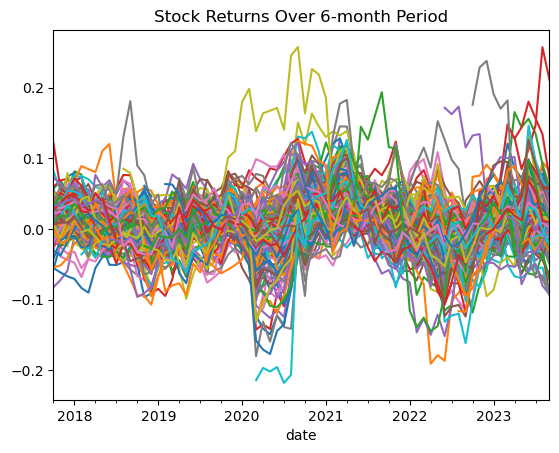

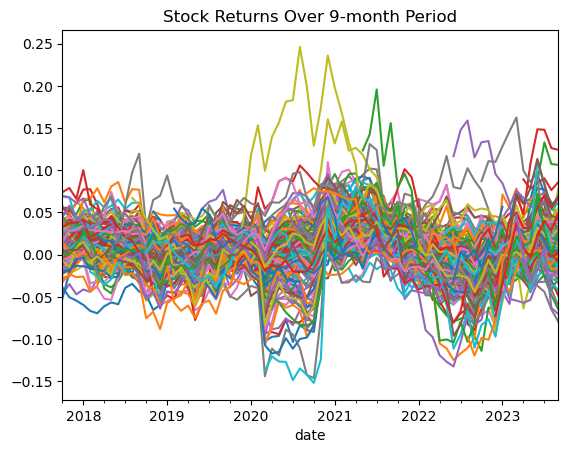

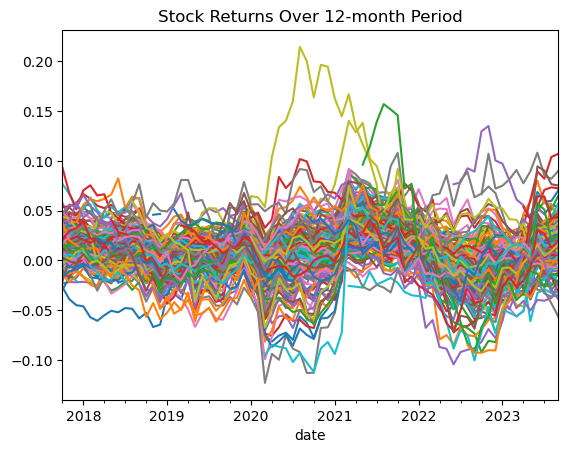

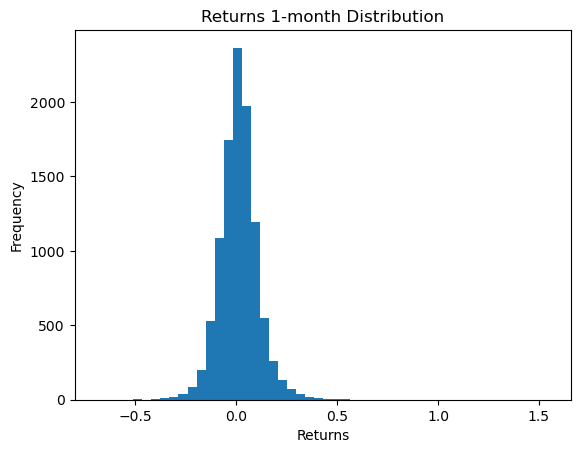

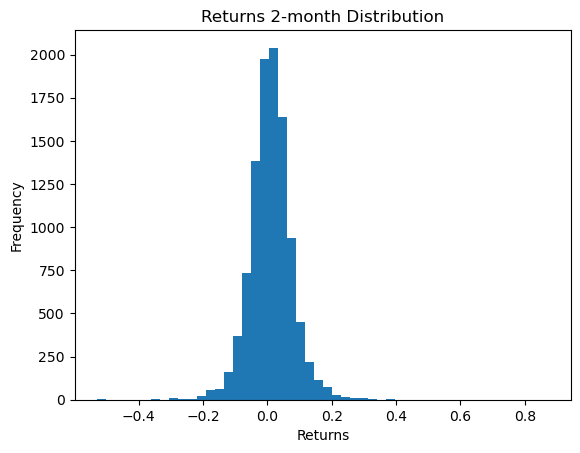

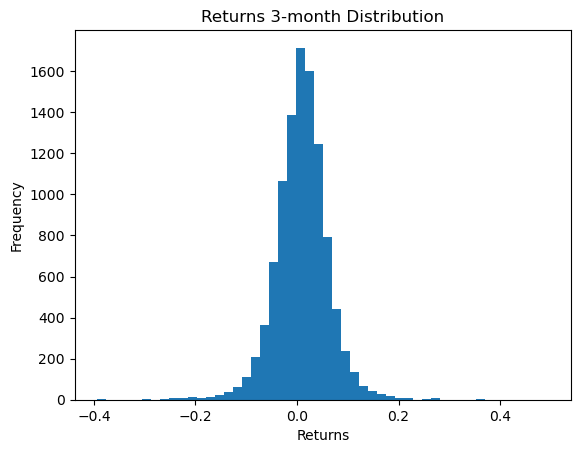

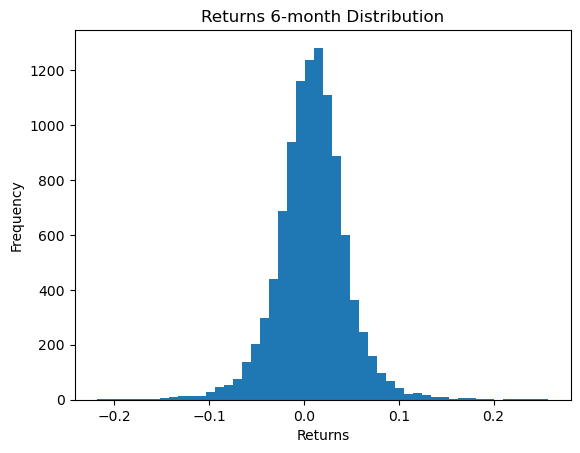

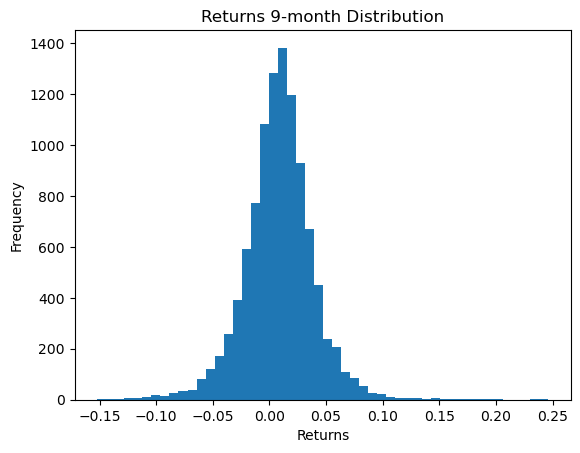

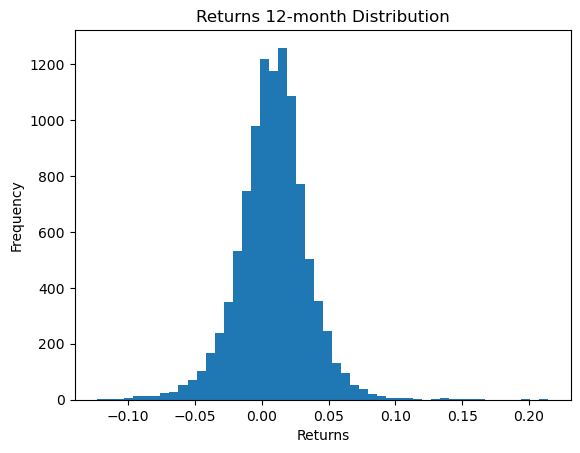

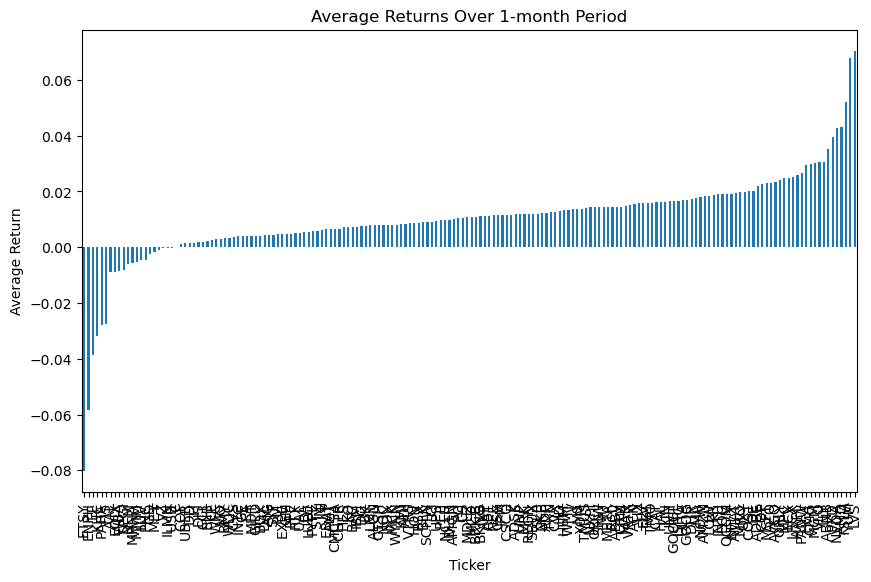

In [15]:
monthly_dollar_volume = df['dollar_volume'].unstack('ticker').resample('M').mean()
sns.heatmap(monthly_dollar_volume, cmap='viridis')
plt.title('Monthly Dollar Volume Heatmap')
plt.xlabel('Ticker')
plt.ylabel('Month')


for lag in [1, 2, 3, 6, 9, 12]:
    data[f'return_{lag}m'].unstack().plot(title=f'Stock Returns Over {lag}-month Period', legend=False)
    plt.show()


for lag in [1, 2, 3, 6, 9, 12]:
    data[f'return_{lag}m'].plot(kind='hist', bins=50, title=f'Returns {lag}-month Distribution')
    plt.xlabel('Returns')
    plt.show()


import matplotlib.pyplot as plt

lag = 1  # Choose the lag you are interested in
# Ensure that 'data' is the DataFrame after the lagged returns have been computed
# Unstack to get tickers as columns, then calculate mean across the date index, finally sort values
average_returns_by_ticker = data[f'return_{lag}m'].unstack(level='ticker').mean(axis=0).sort_values()

# Plotting
average_returns_by_ticker.plot(kind='bar', figsize=(10, 6), title=f'Average Returns Over {lag}-month Period')
plt.xlabel('Ticker')
plt.ylabel('Average Return')
plt.show()


## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [16]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10340 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [17]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10309 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [18]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332656 -0.165644  0.267344  0.310366  0.106903
           WFC     1.121747  0.300520  2.061531 -0.439490 -1.517555
           WMT     0.700557 -0.315600 -0.413433 -0.142906  0.508472
           XOM     0.983510 -1.093758  1.756775 -0.640866 -0.368453

[10309 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [19]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10065 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10065 non-null  float64
 1   bb_high           10065 non-null  float64
 2   bb_low            10065 non-null  float64
 3   bb_mid            10065 non-null  float64
 4   garman_klass_vol  10065 non-null  float64
 5   macd              10065 non-null  float64
 6   rsi               10065 non-null  float64
 7   return_1m         10065 non-null  float64
 8   return_2m         10065 non-null  float64
 9   return_3m         10065 non-null  float64
 10  return_6m         10065 non-null  float64
 11  return_9m         10065 non-null  float64
 12  return_12m        10065 non-null  float64
 13  Mkt-RF            10065 non-null  float64
 14  SMB               10065 non-null  float64
 15  HML       

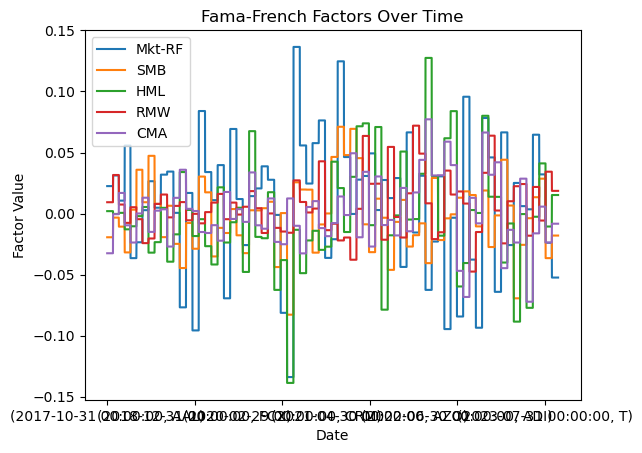

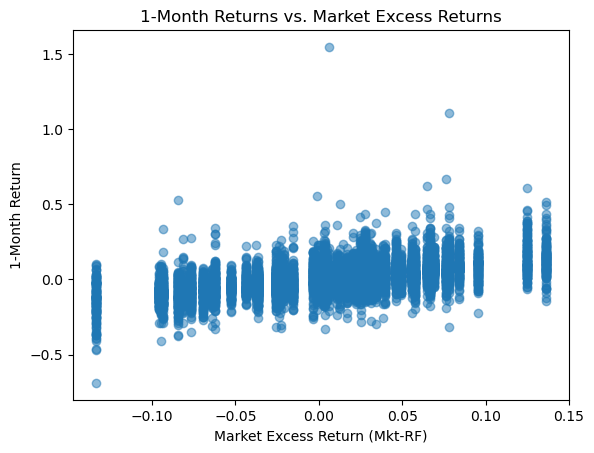

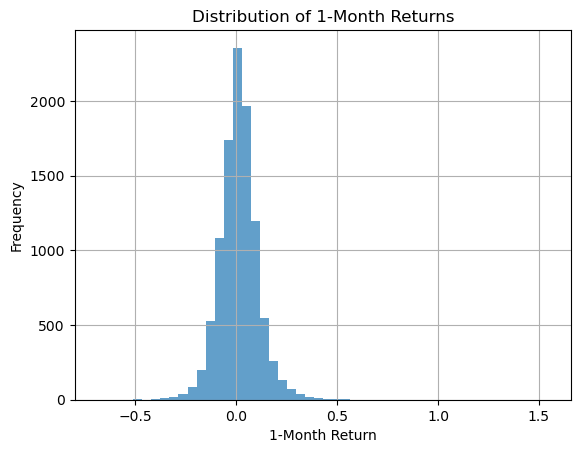

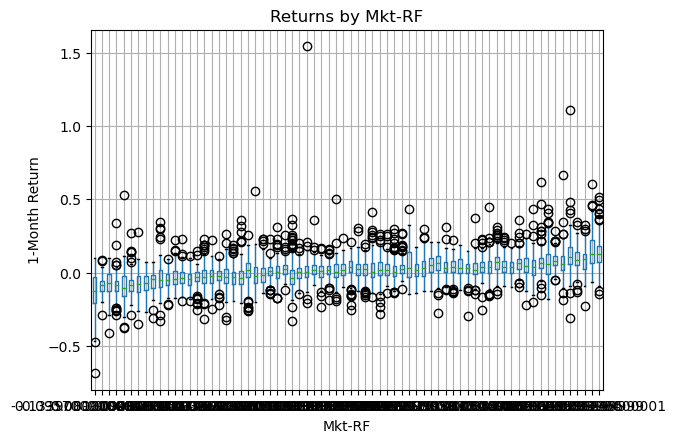

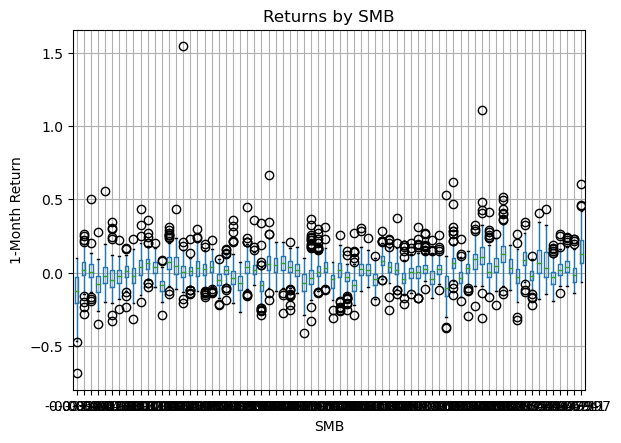

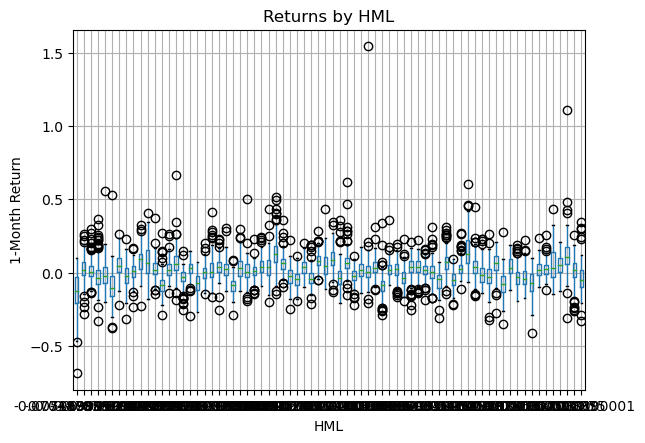

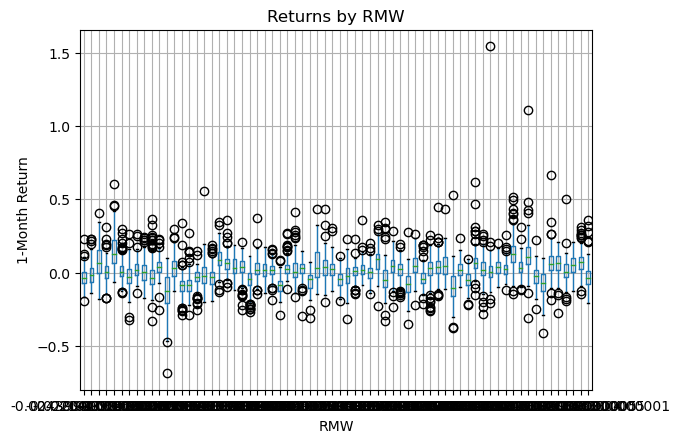

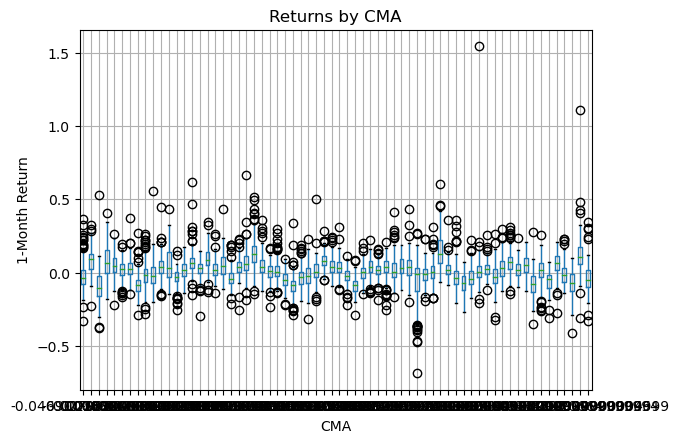

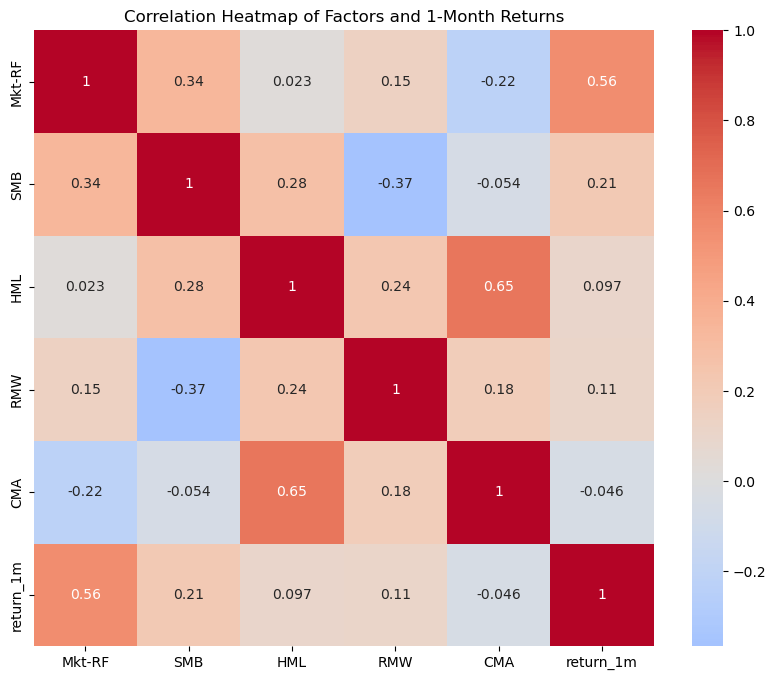

In [20]:
factor_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].plot(title='Fama-French Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Factor Value')
plt.show()


plt.scatter(factor_data['Mkt-RF'], factor_data['return_1m'], alpha=0.5)
plt.title('1-Month Returns vs. Market Excess Returns')
plt.xlabel('Market Excess Return (Mkt-RF)')
plt.ylabel('1-Month Return')
plt.show()


factor_data['return_1m'].hist(bins=50, alpha=0.7)
plt.title('Distribution of 1-Month Returns')
plt.xlabel('1-Month Return')
plt.ylabel('Frequency')
plt.show()


for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']:
    factor_data.boxplot(column='return_1m', by=factor)
    plt.title(f'Returns by {factor}')
    plt.suptitle('')
    plt.xlabel(factor)
    plt.ylabel('1-Month Return')
    plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'factor_data' is the DataFrame from the provided code
# We first need to calculate the correlation matrix
correlation_matrix = factor_data.corr()

# Then, we can plot a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Factors and 1-Month Returns')
plt.show()

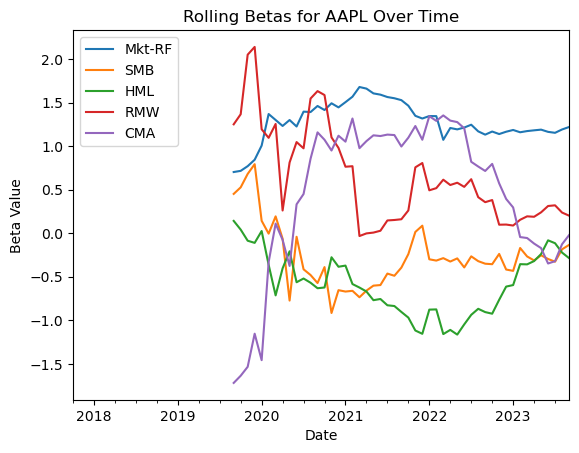

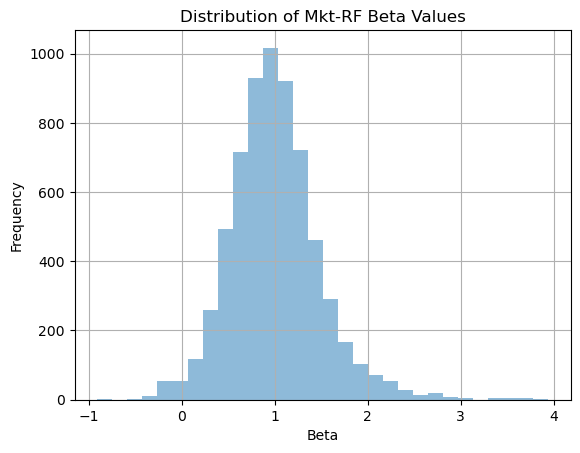

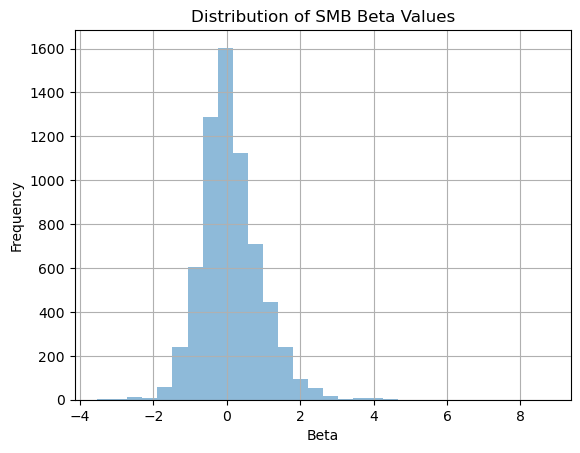

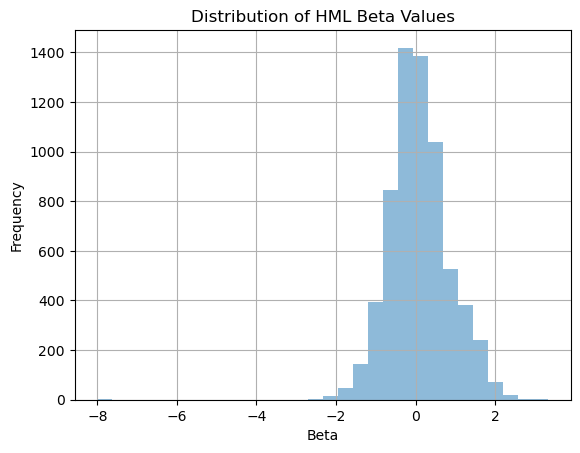

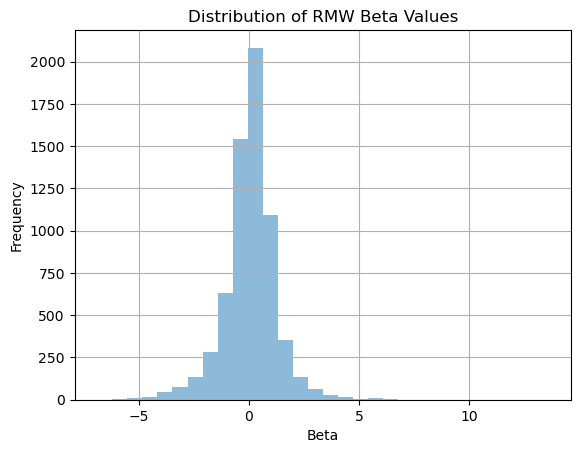

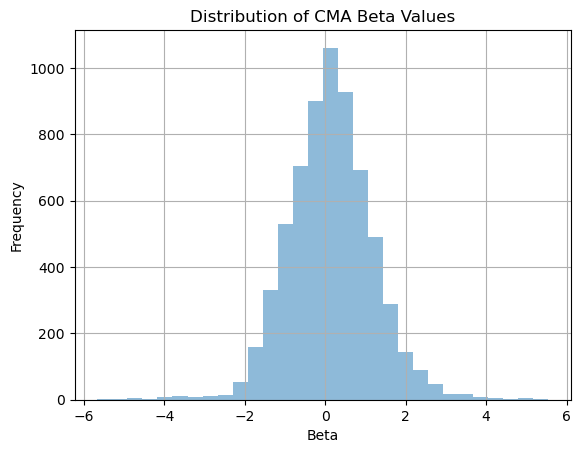

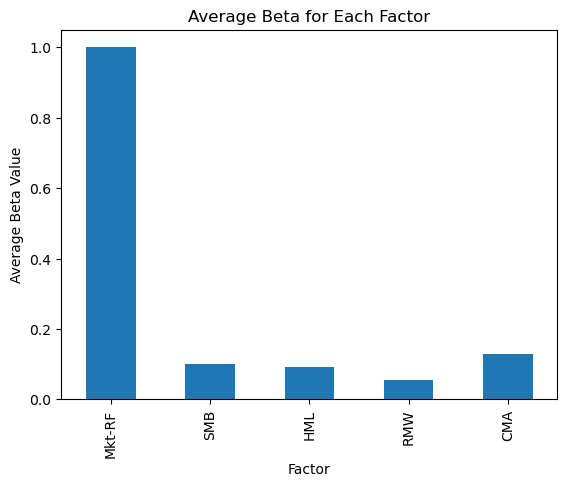

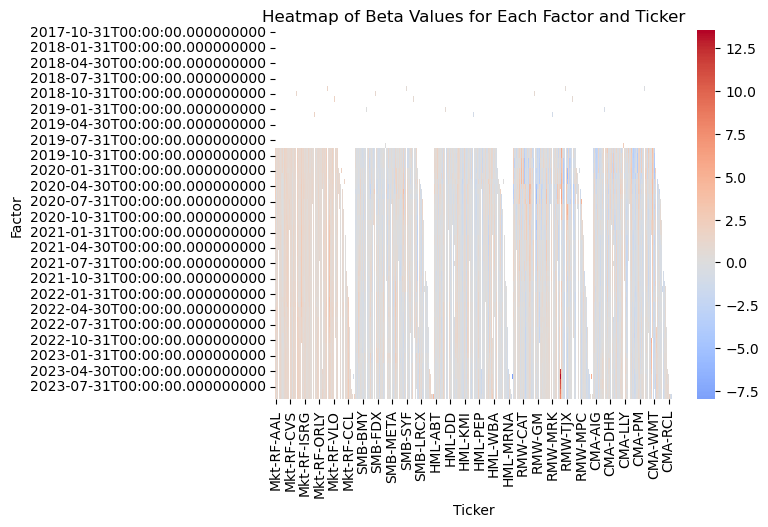

In [21]:
ticker = 'AAPL'  # Replace with the ticker of interest
betas.xs(ticker, level='ticker')[factors].plot(title=f'Rolling Betas for {ticker} Over Time')
plt.xlabel('Date')
plt.ylabel('Beta Value')
plt.show()


for factor in factors:
    betas[factor].hist(bins=30, alpha=0.5)
    plt.title(f'Distribution of {factor} Beta Values')
    plt.xlabel('Beta')
    plt.ylabel('Frequency')
    plt.show()


average_betas = betas.mean()
average_betas.plot(kind='bar', title='Average Beta for Each Factor')
plt.xlabel('Factor')
plt.ylabel('Average Beta Value')
plt.show()


beta_heatmap_data = betas[factors].unstack('ticker')  # Transform so that each column is a ticker
sns.heatmap(beta_heatmap_data, cmap='coolwarm', center=0)
plt.title('Heatmap of Beta Values for Each Factor and Ticker')
plt.xlabel('Ticker')
plt.ylabel('Factor')
plt.show()


### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [22]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [23]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.689797  3.596048  3.642922         -0.000997   
           ABBV    0.375557  4.289423  4.196702  4.243063         -0.034008   
           ABT    -1.040044  3.939707  3.892568  3.916137         -0.005190   
           ACN    -0.986514  4.882034  4.802675  4.842354         -0.003925   
...                     ...       ...       ...       ...               ...   
2023-09-30 WFC    -0.558742  3.783384  3.702645  3.743015          0.000016   
           WMT    -0.196381  4.023309  3.988367  4.005838         -0.000011   
           XOM     0.601335  4.775304  4.695106  4.735205          0.000026   
           MRNA   -0.529511  4.788149  4.582514  4.685332          0.000146   
           UBER   -0.746098  3.917801  3.806654  3.862227          0.000441   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018697  41.051803  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196704   0.096808   0.015250   0.044955   
           ABBV    0.473813  55.247809   0.022728   0.098590   0.091379   
           ABT     0.276133  53.844864   0.021276   0.034308   0.034801   
           ACN     0.352343  69.365517   0.064180   0.048455   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 WFC    -0.282325  40.920277  -0.015500  -0.057917  -0.013554   
           WMT     0.399459  54.722560  -0.000676   0.010014   0.012354   
           XOM     1.400623  59.440179   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035229  1.275749 -0.271693   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166699   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000702    0.003255  1.137640  0.314482   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051368   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        1  
           AAPL   -0.591146  0.647781  0.458080        3  
           ABBV   -0.033099  0.241979  0.164917        2  
           ABT    -0.529385  0.252408  0.970211        2  
           ACN    -0.328214  0.267790  0.168886        3  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009072 -0.404338 -1.468837        1  
           WMT    -0.522677 -0.126426  0.642627        3  
           XOM     1.707833 -0.675679 -0.284024        3  
           MRNA   -1.165677  0.590306  0.993548        1  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10065 rows x 19 columns]

In [24]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


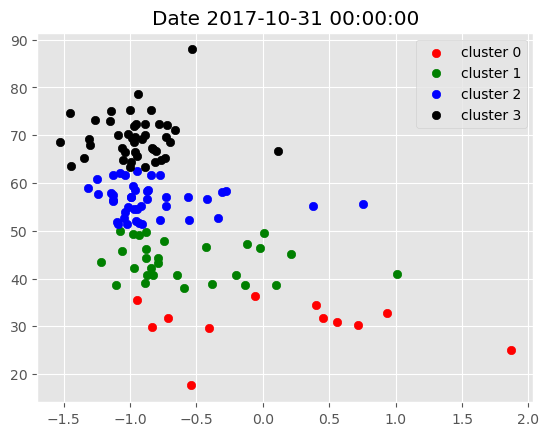

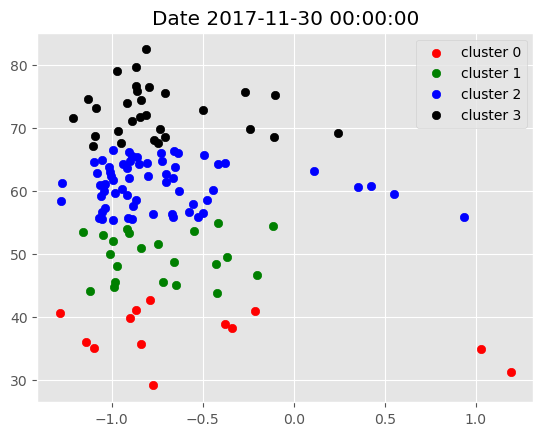

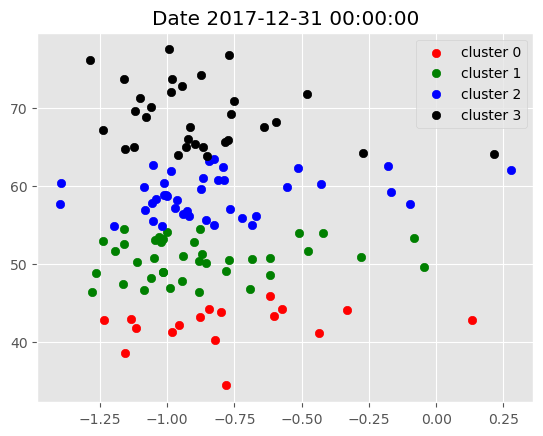

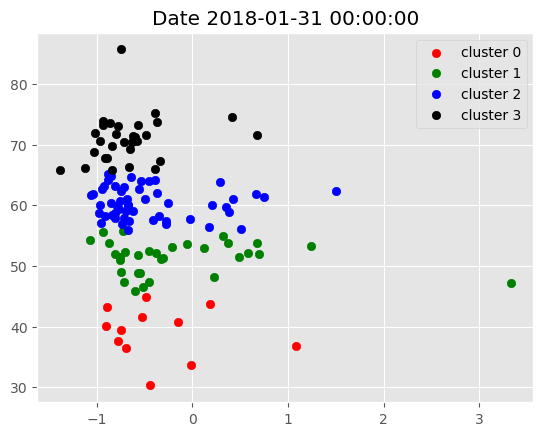

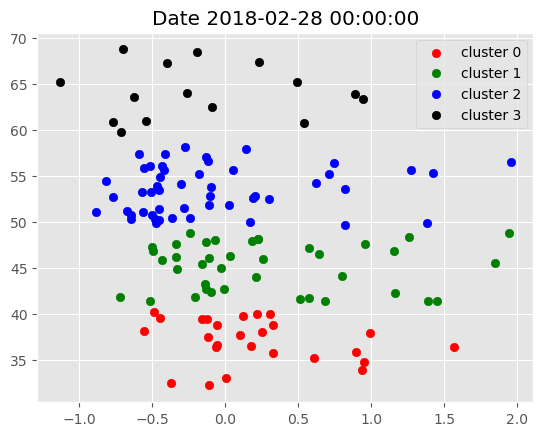

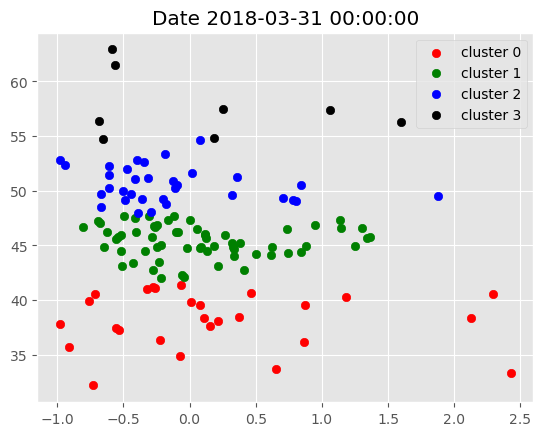

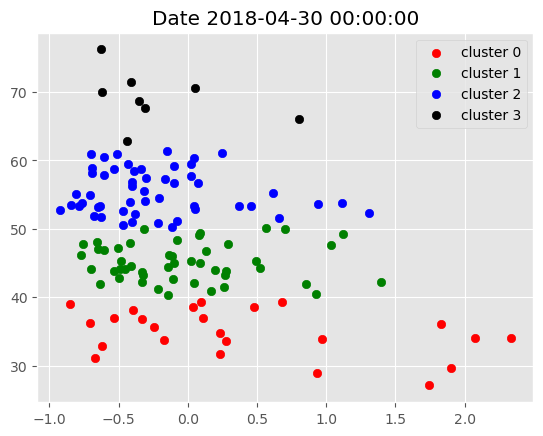

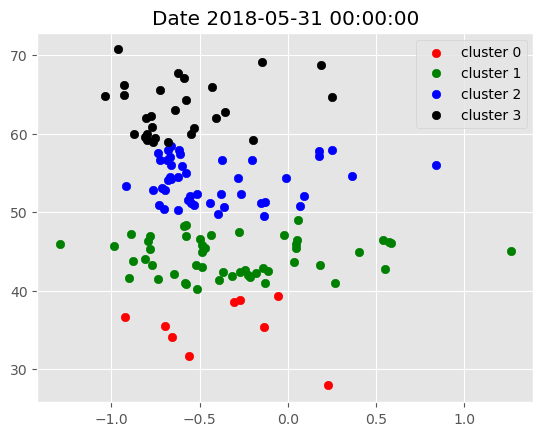

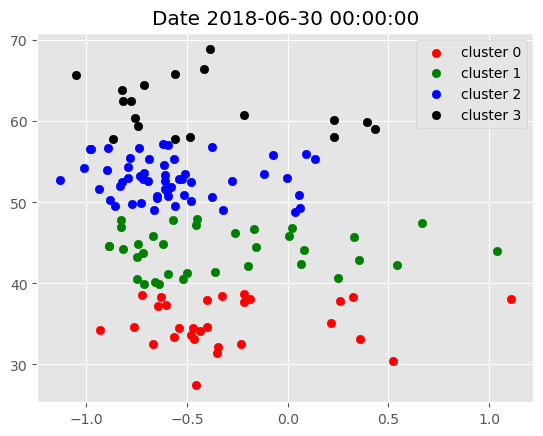

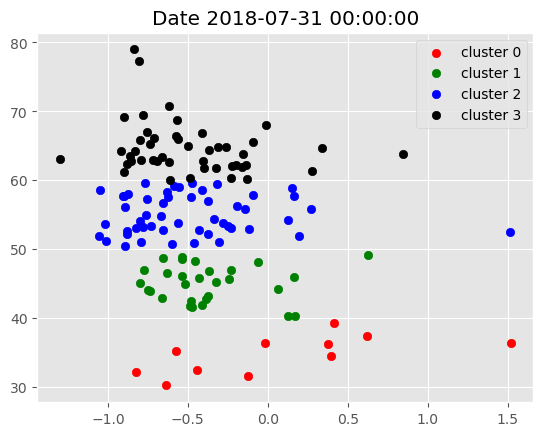

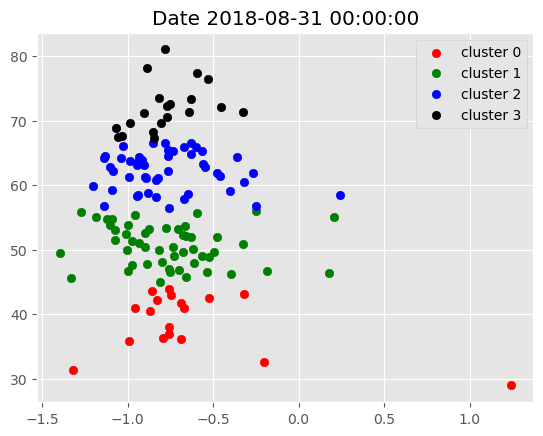

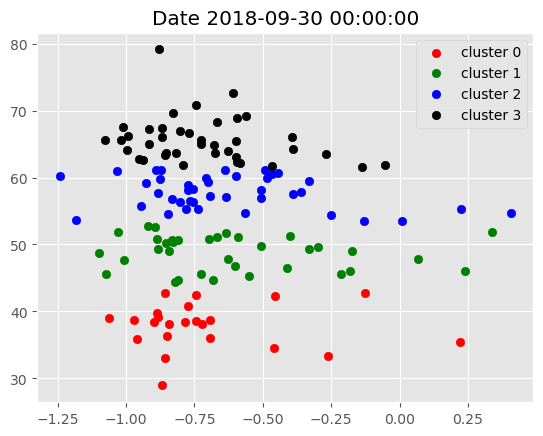

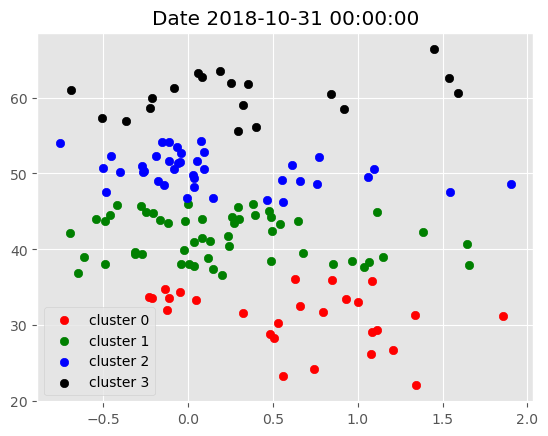

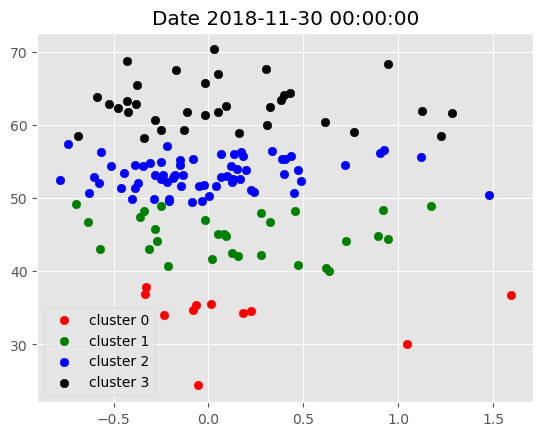

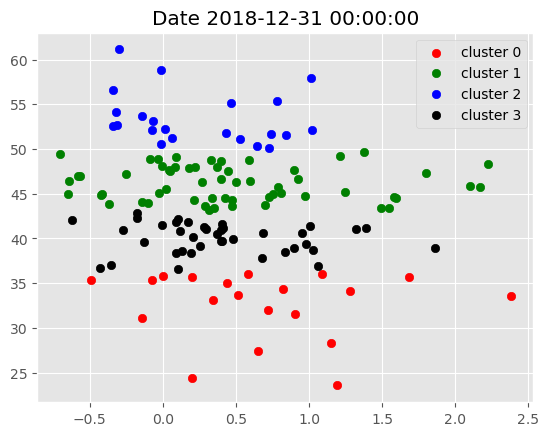

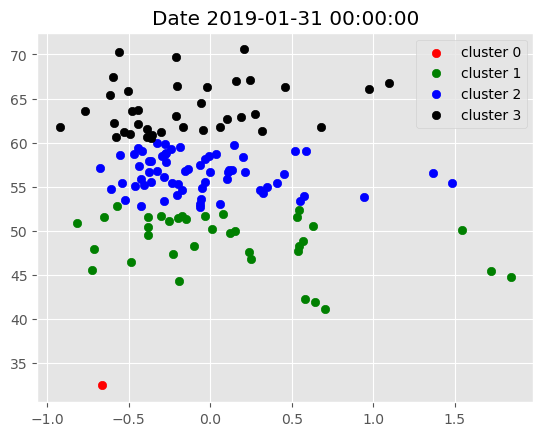

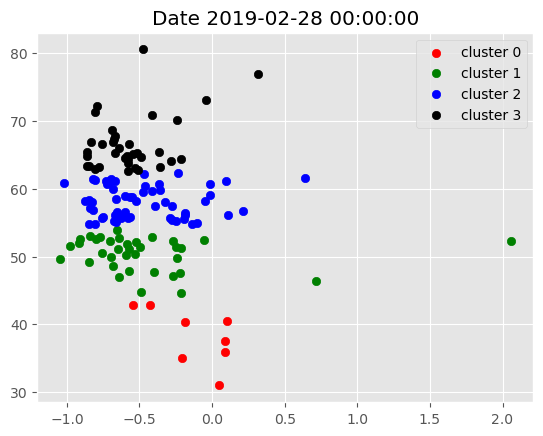

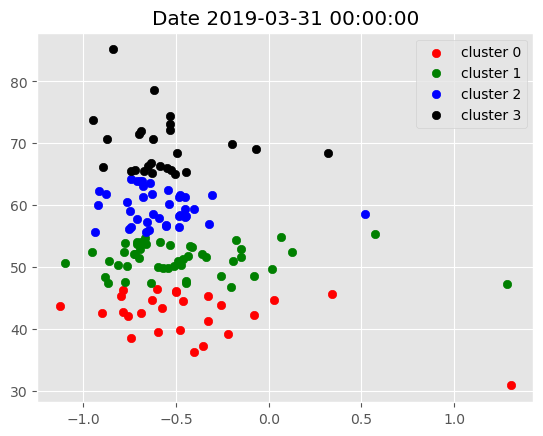

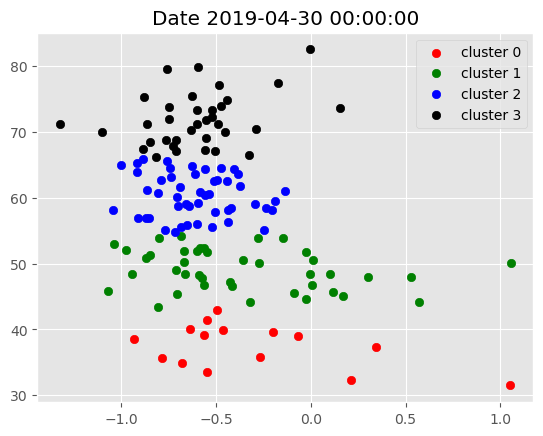

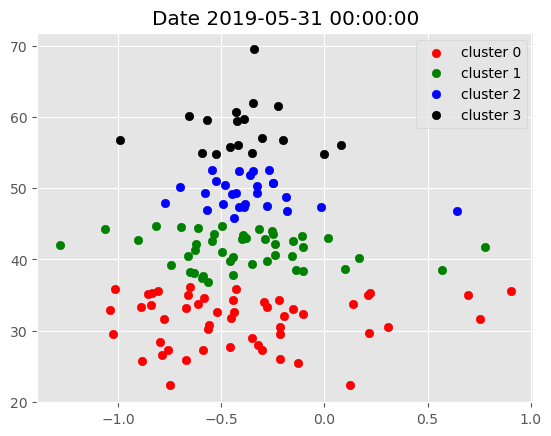

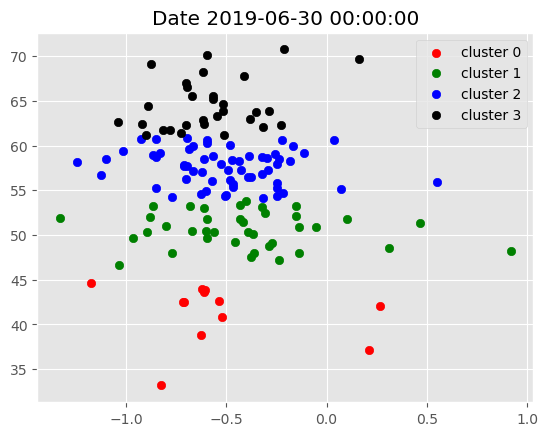

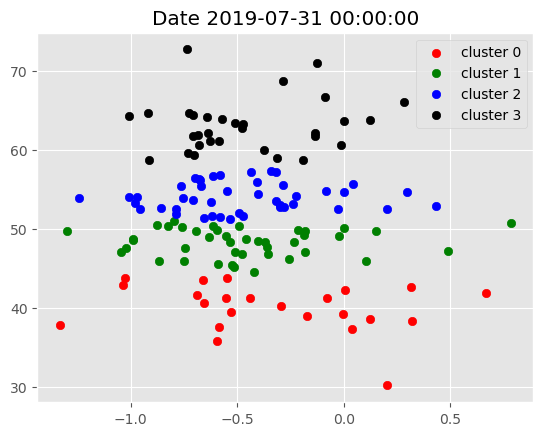

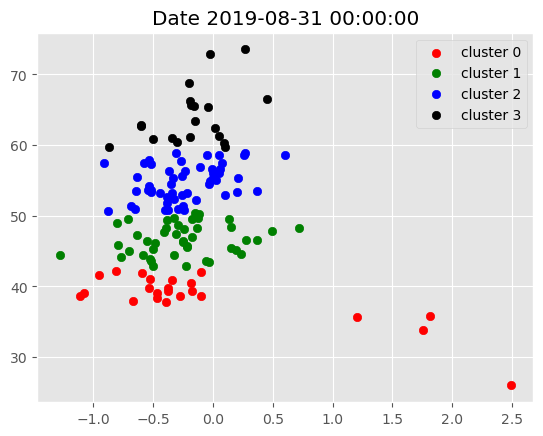

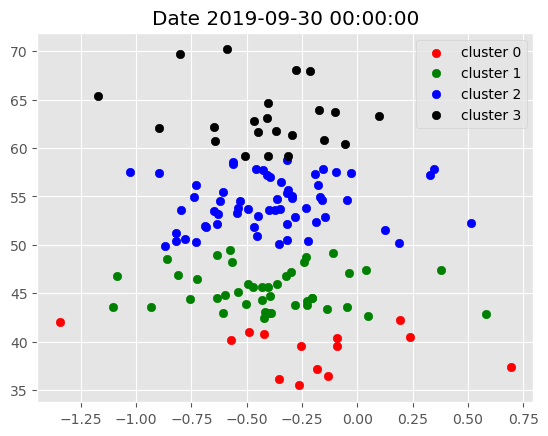

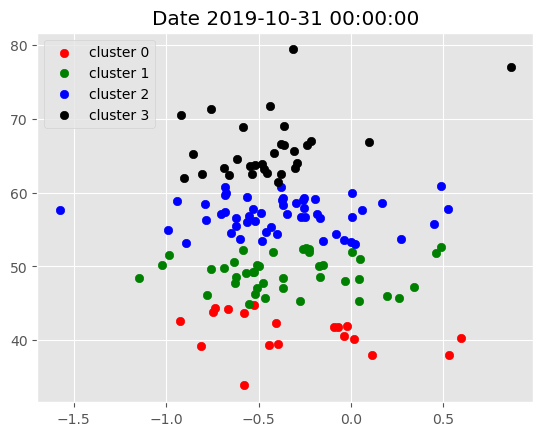

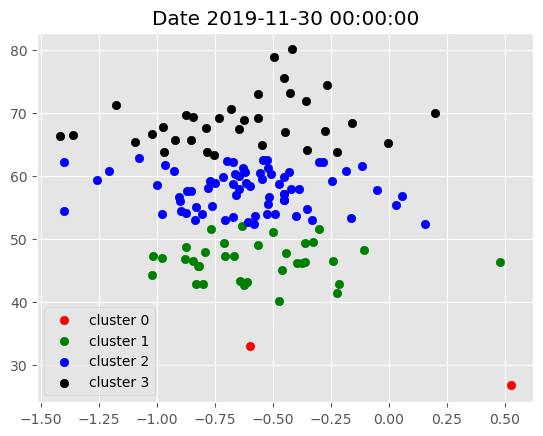

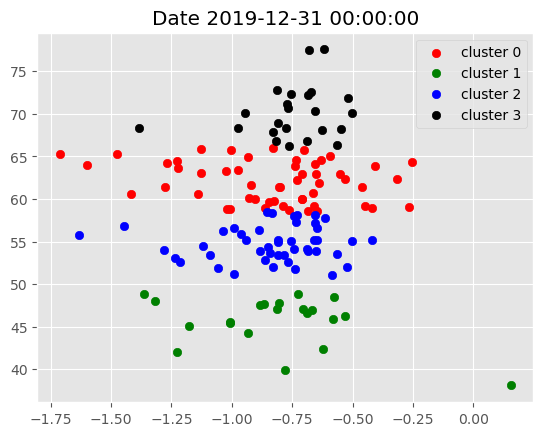

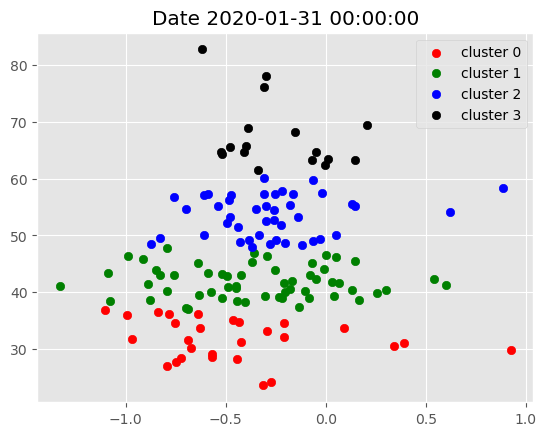

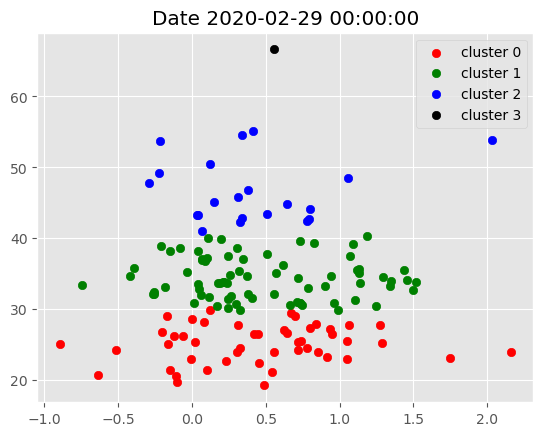

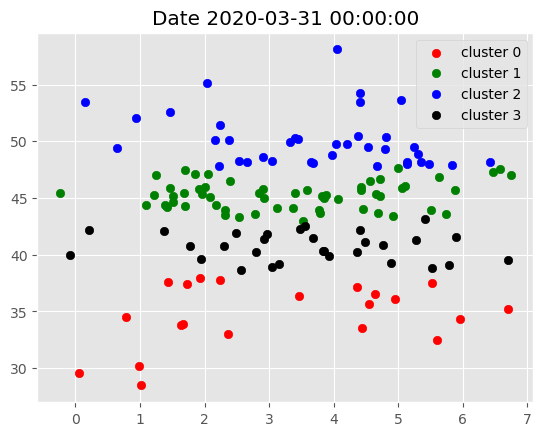

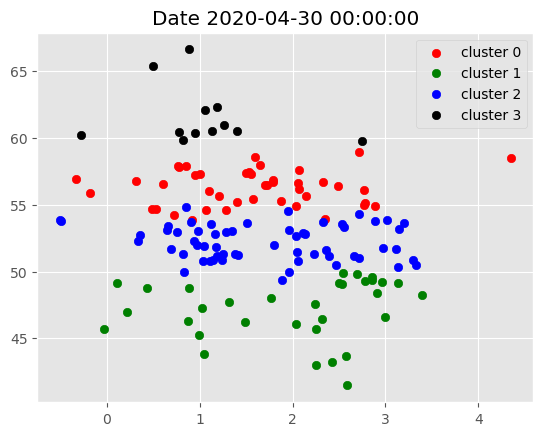

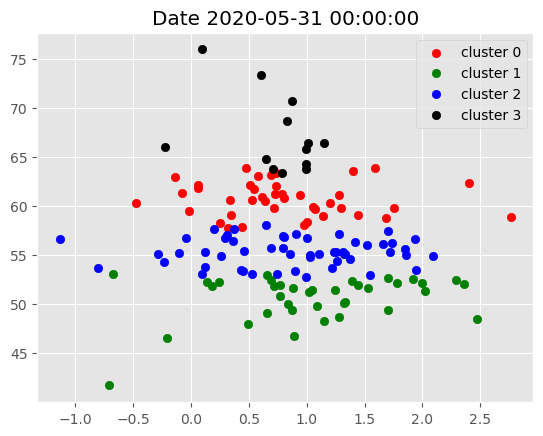

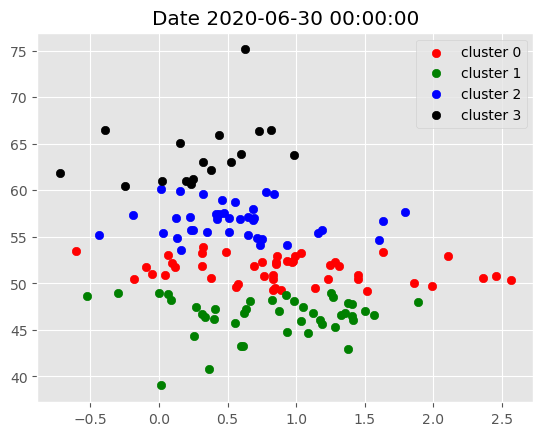

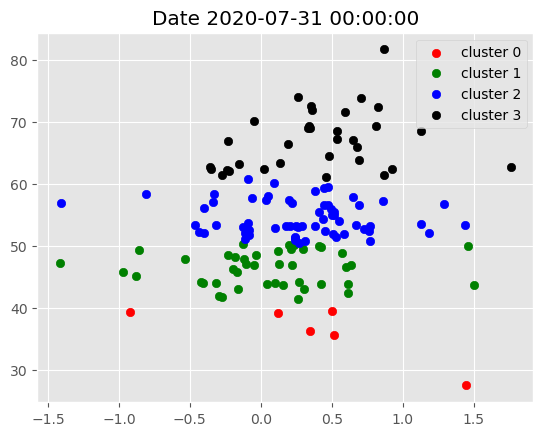

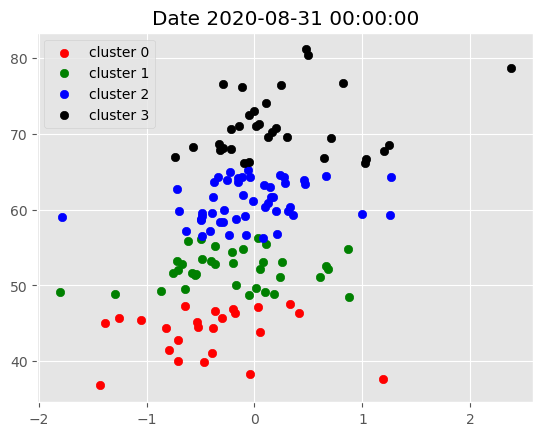

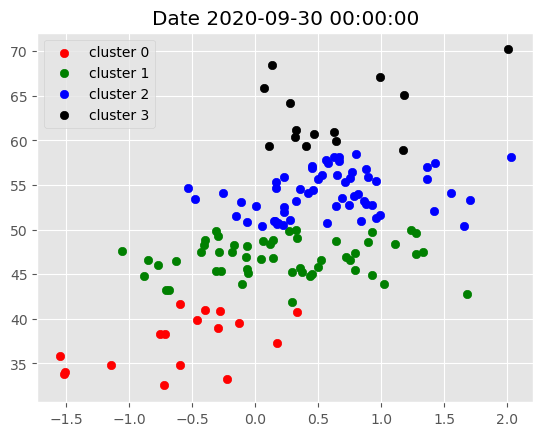

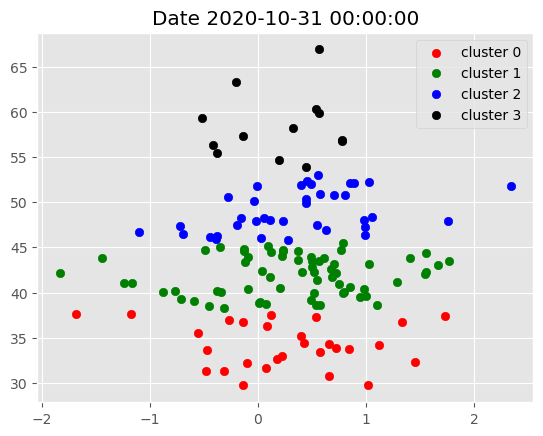

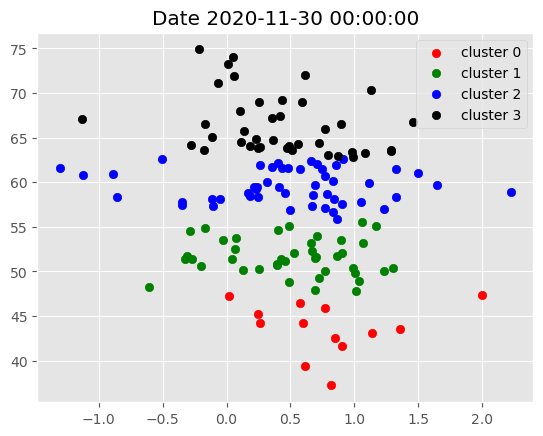

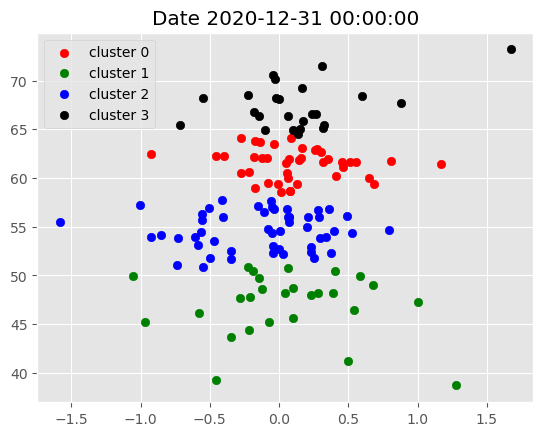

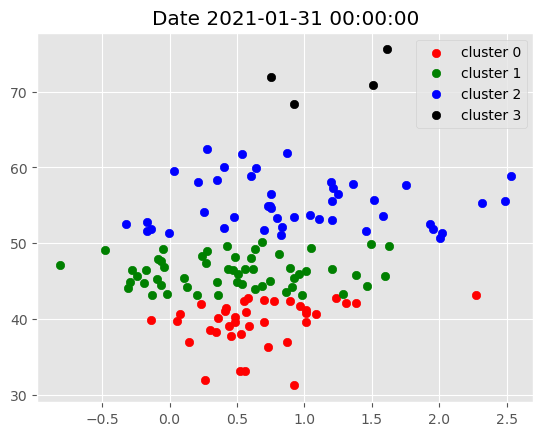

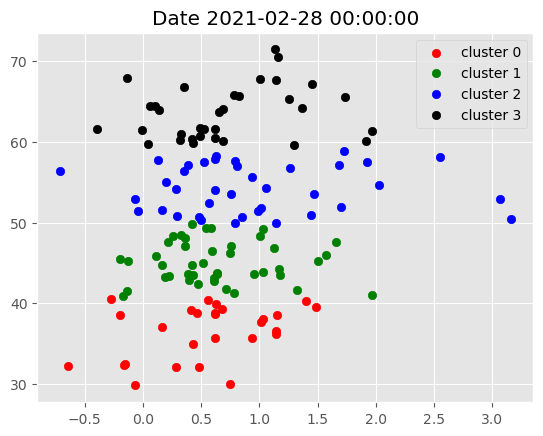

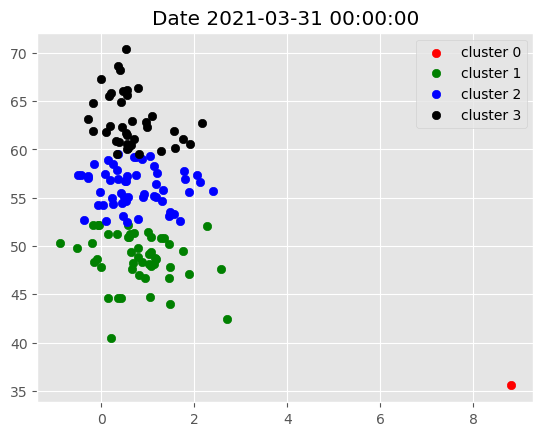

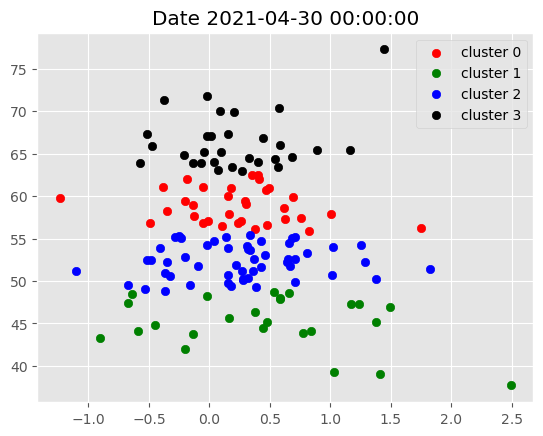

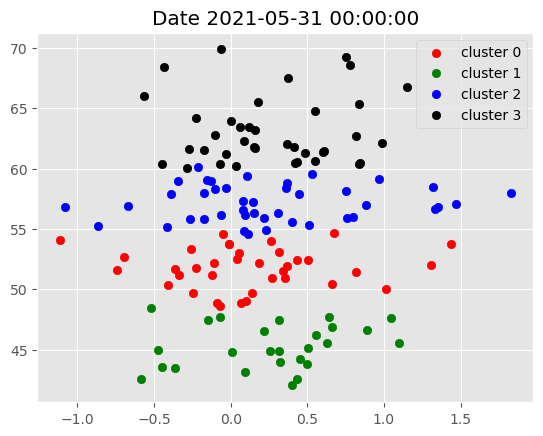

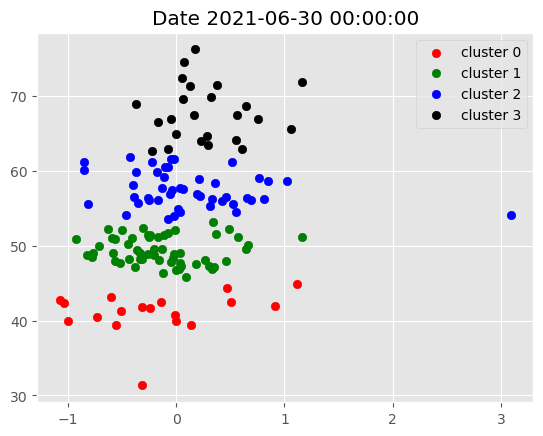

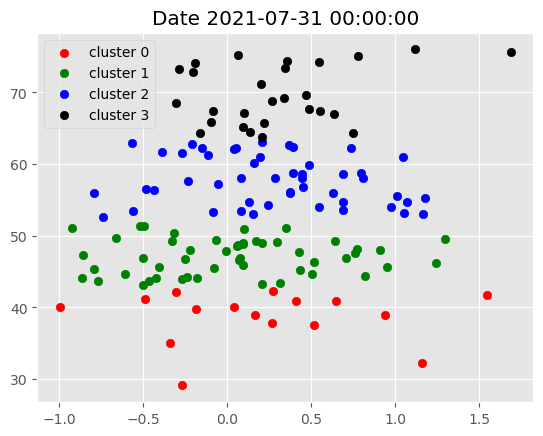

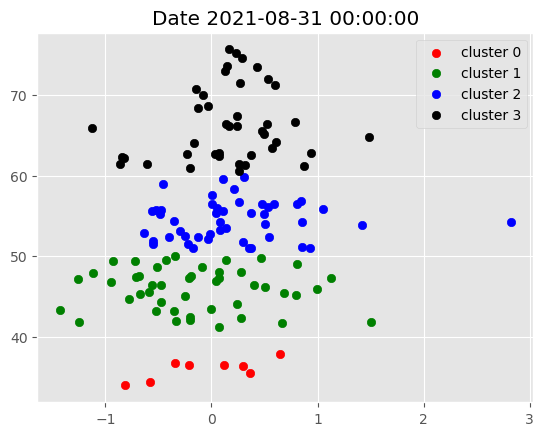

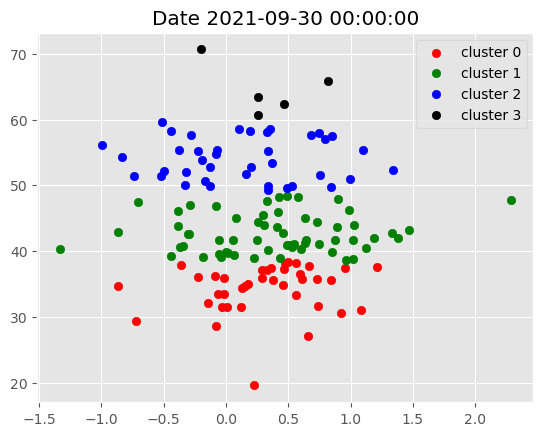

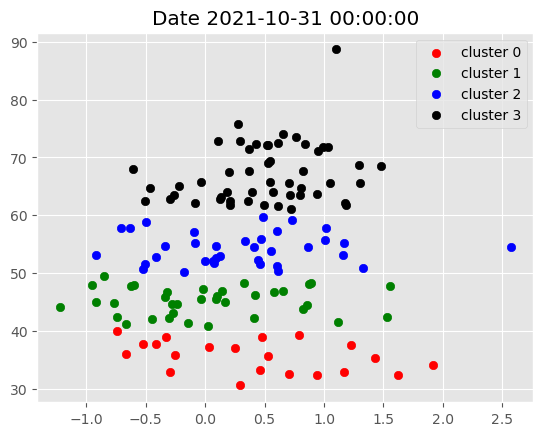

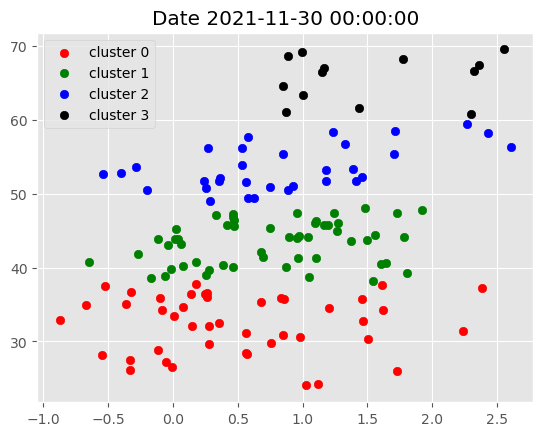

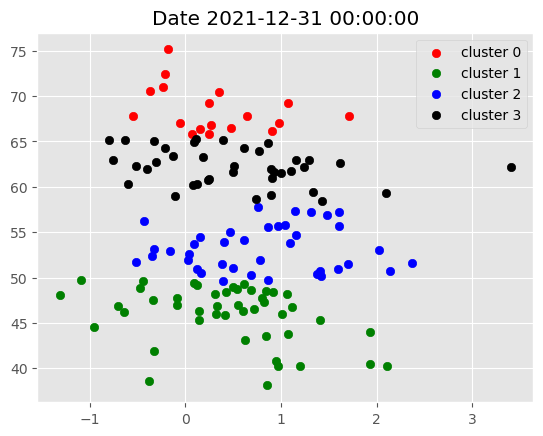

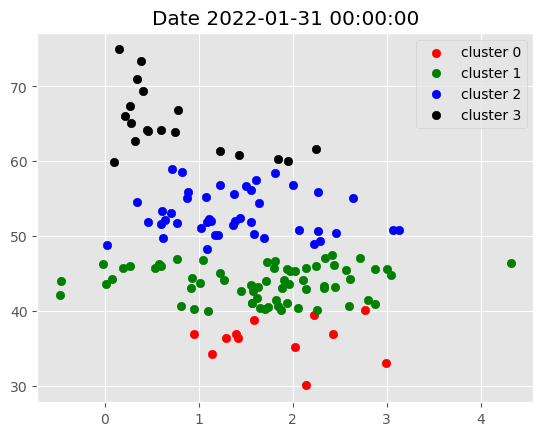

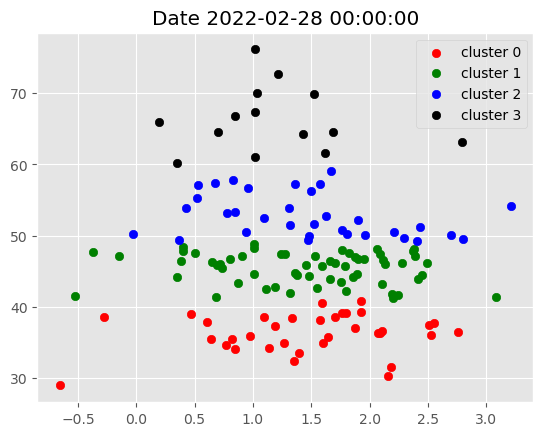

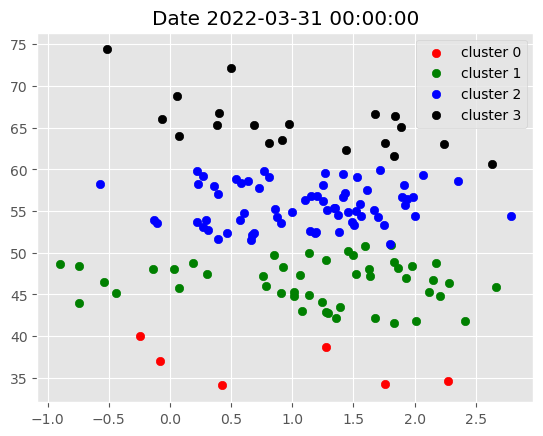

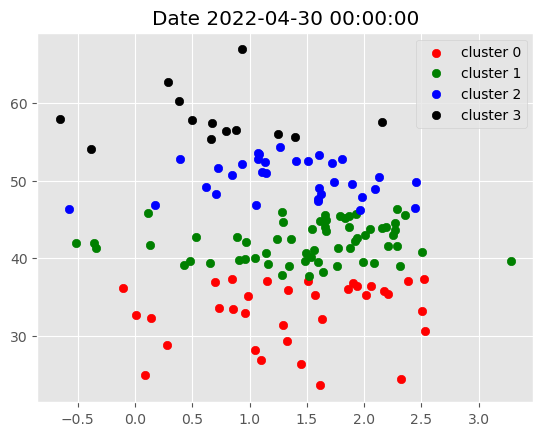

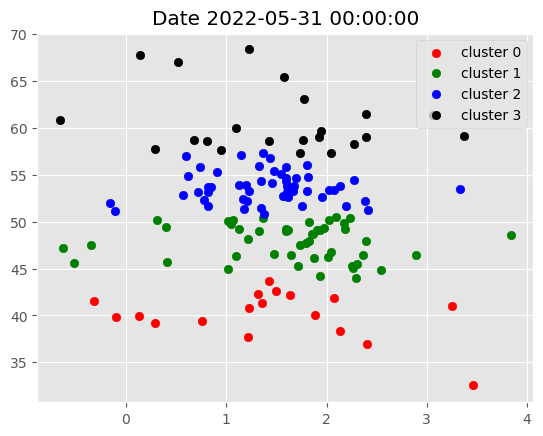

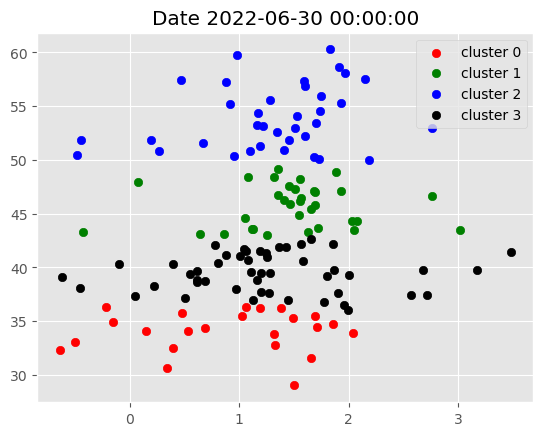

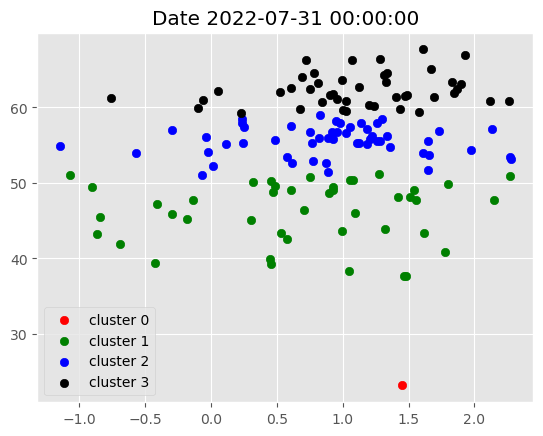

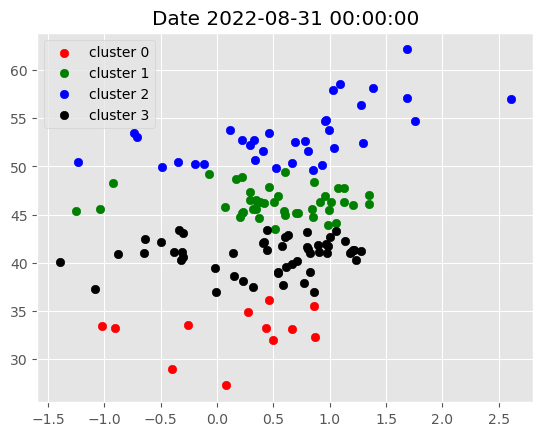

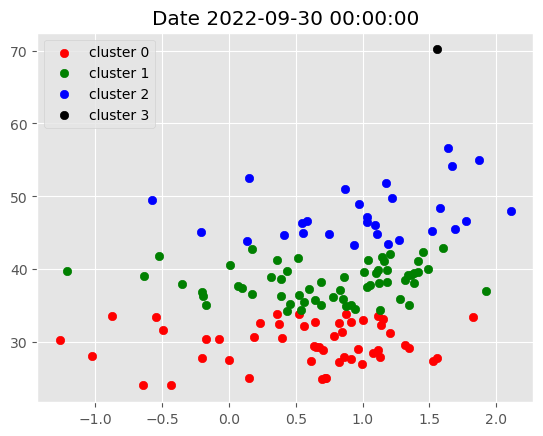

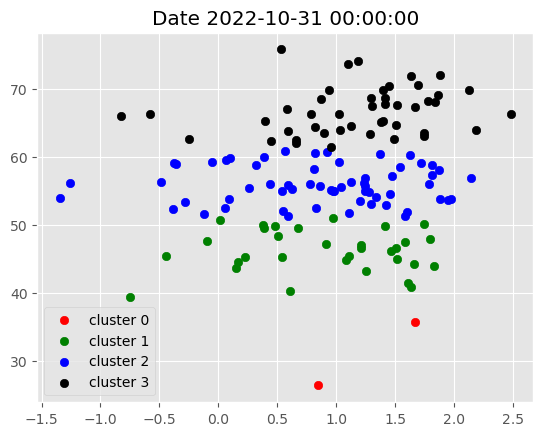

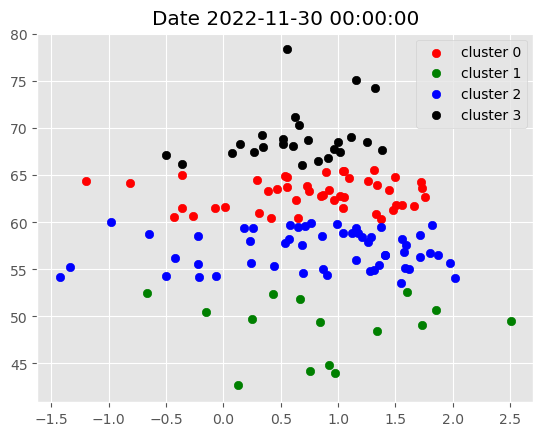

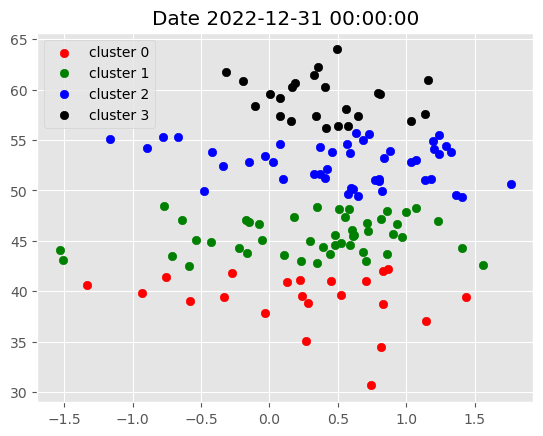

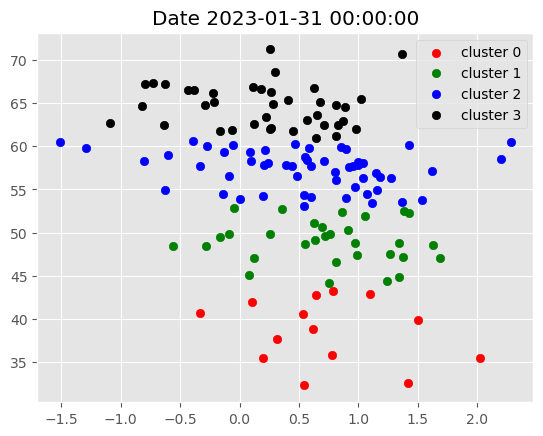

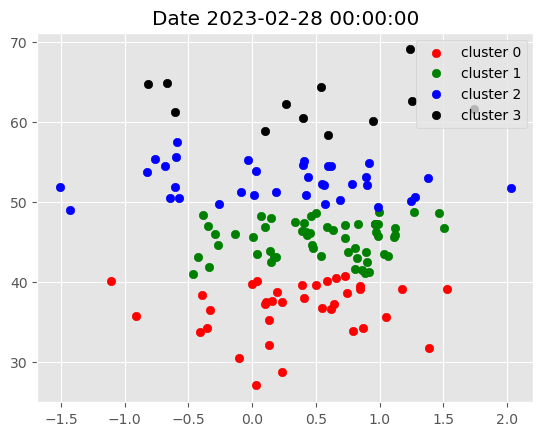

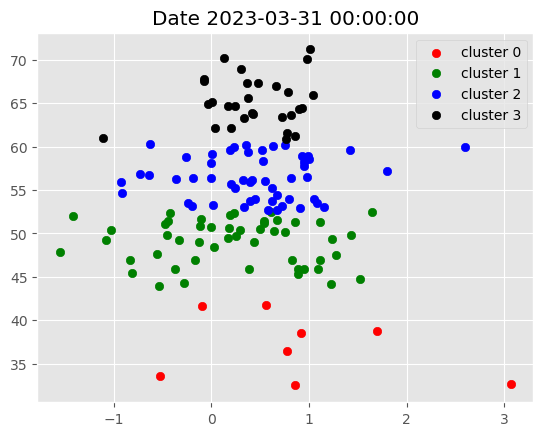

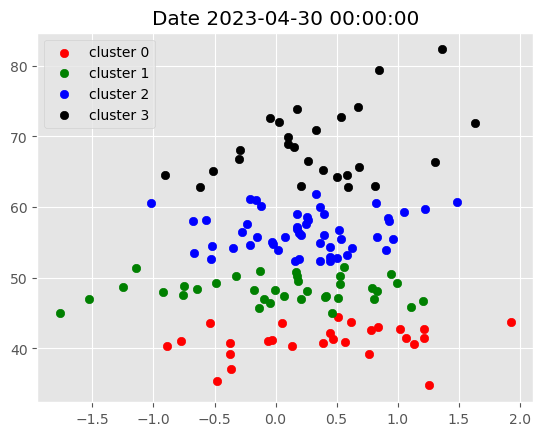

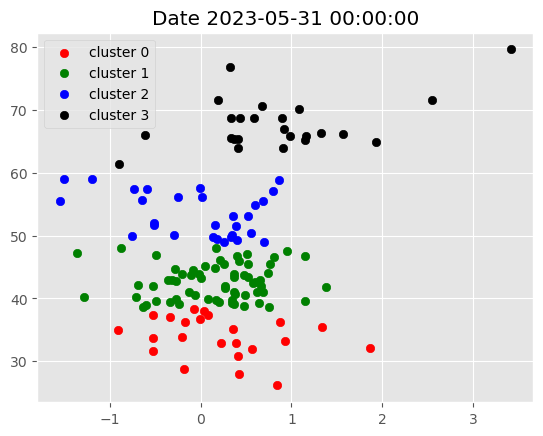

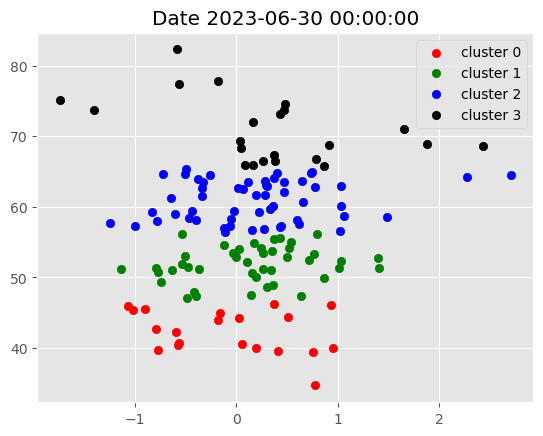

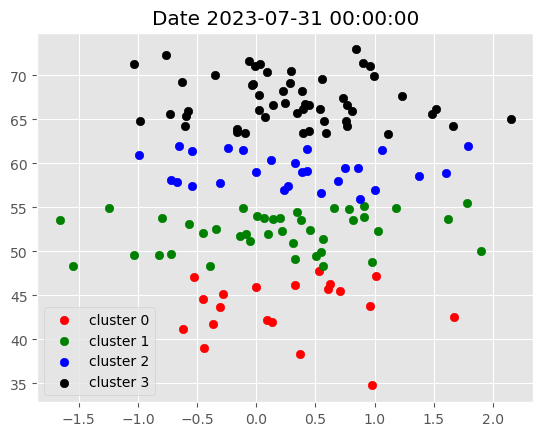

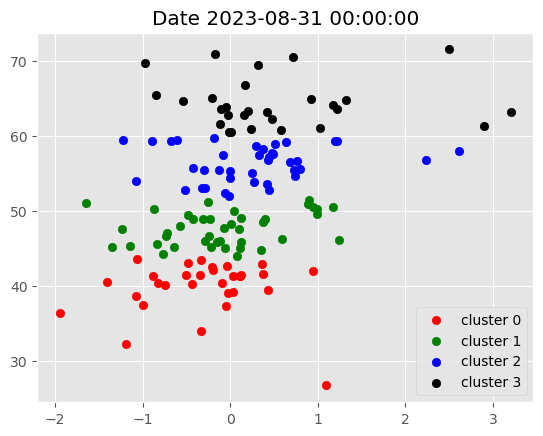

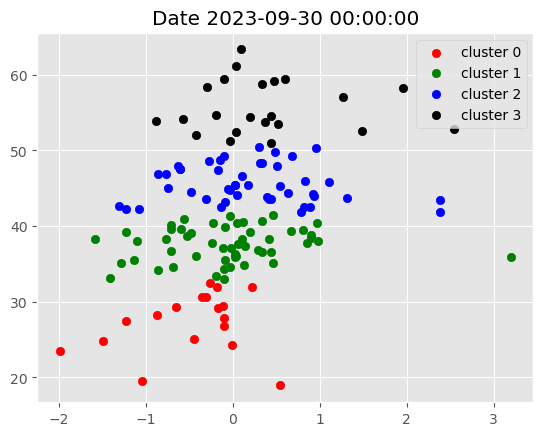

In [25]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

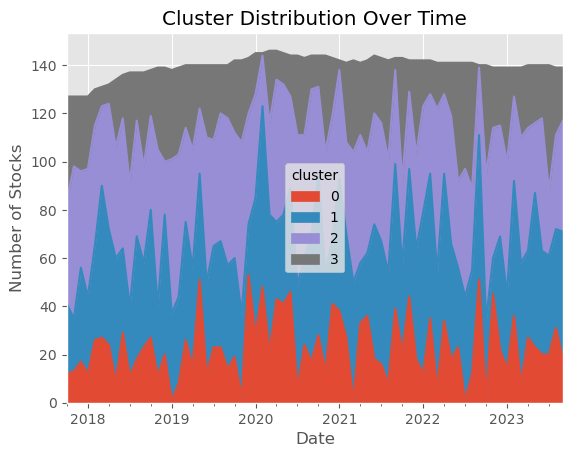

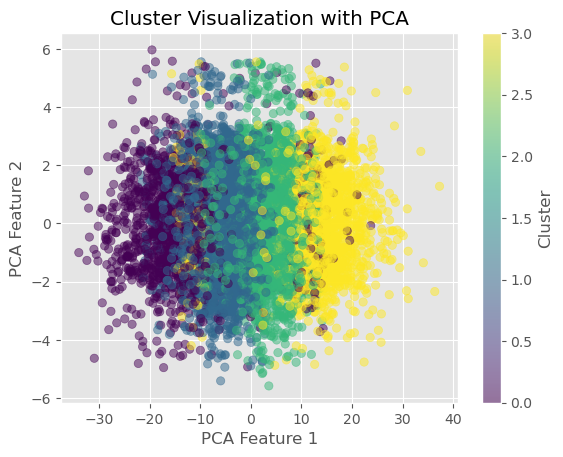

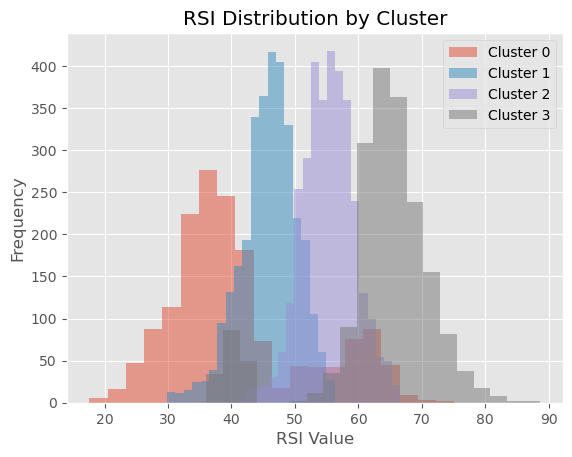

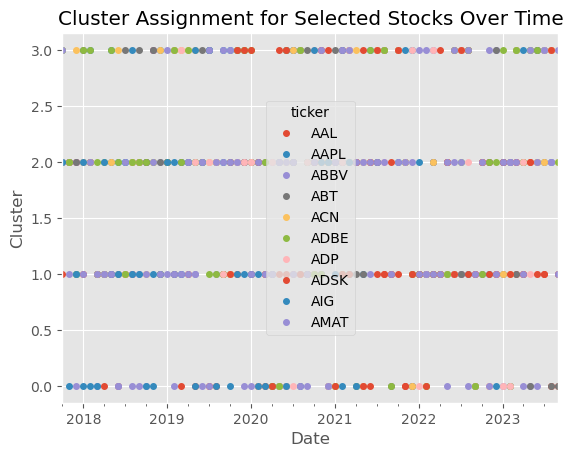

In [26]:
cluster_counts = data['cluster'].groupby('date').value_counts().unstack().fillna(0)
cluster_counts.plot(kind='area', stacked=True, title='Cluster Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Stocks')
plt.show()


from sklearn.decomposition import PCA

# Reduce the dimensionality of the data for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data.drop(['cluster'], axis=1))

# Create a scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.title('Cluster Visualization with PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()


for cluster in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster]
    cluster_data['rsi'].plot(kind='hist', bins=20, alpha=0.5, label=f'Cluster {cluster}')
plt.title('RSI Distribution by Cluster')
plt.xlabel('RSI Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# You need to pivot your data so that dates are the index and columns are the stocks
cluster_time_series = data['cluster'].unstack('ticker')  # Assuming 'ticker' is a level in your index

# Select a subset of tickers to visualize
tickers_to_visualize = cluster_time_series.columns[:10]  # Replace with your tickers of interest
cluster_time_series[tickers_to_visualize].plot(marker='o', linestyle='', ms=4)
plt.title('Cluster Assignment for Selected Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Cluster')
plt.show()


## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [27]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [28]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [29]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  154 of 154 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134335   26.248028   40.245125  34.293457  103.569641   
2016-11-01  38.363209   25.774113   40.728523  34.127403  103.480537   
2016-11-02  38.276455   25.797230   40.973835  33.821522  105.681305   
2016-11-03  38.054203   25.520716   40.324486  33.541862  104.202232   
2016-11-04  38.402088   25.290674   40.432701  34.162357  104.451736   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.624222  150.264954  95.991318  313.318970   
2023-09-26  12.700000  171.514893  149.545944  94.770142  307.012848   
2023-09-27  12.610000  169.988831  148.788071  94.080750  310.739227   
2023-09-28  12.920000  170.248184  147.933029  96.631462  297.286804   
2023-09-29  12.810000  170.766830  144.833466  95.380722  303.553406   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   74.257103   72.279999  50.735886   26.654831  ...   
2016-11-01  106.870003   74.137695   70.099998  49.897148   26.489849  ...   
2016-11-02  105.889999   76.747719   68.680000  49.790253   26.205698  ...   
2016-11-03  107.169998   76.193283   67.610001  47.816727   25.912382  ...   
2016-11-04  106.199997   75.980064   69.440002  47.183556   25.866554  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  237.203598  205.669998  61.502777  136.066544  ...   
2023-09-26  506.299988  234.456207  201.660004  60.641556  133.566162  ...   
2023-09-27  502.600006  239.782959  202.279999  60.394081  134.542419  ...   
2023-09-28  504.670013  240.454971  207.889999  60.661354  137.690292  ...   
2023-09-29  509.899994  237.757019  206.910004  59.988220  137.919418  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

                                         
                 WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 924 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [30]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


Strategy Return
date                       
2017-11-01         0.001371
2017-11-02         0.003015
2017-11-03         0.006222
2017-11-06         0.002973
2017-11-07         0.002645
...                     ...
2023-09-25         0.003641
2023-09-26        -0.011470
2023-09-27         0.005189
2023-09-28         0.007977
2023-09-29        -0.007698

[1487 rows x 1 columns]

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [31]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2017-11-01         0.001371      0.001321
2017-11-02         0.003015      0.000388
2017-11-03         0.006222      0.003333
2017-11-06         0.002973      0.001546
2017-11-07         0.002645     -0.000695
...                     ...           ...
2023-09-25         0.003641      0.004196
2023-09-26        -0.011470     -0.014800
2023-09-27         0.005189      0.000399
2023-09-28         0.007977      0.005781
2023-09-29        -0.007698     -0.002430

[1487 rows x 2 columns]

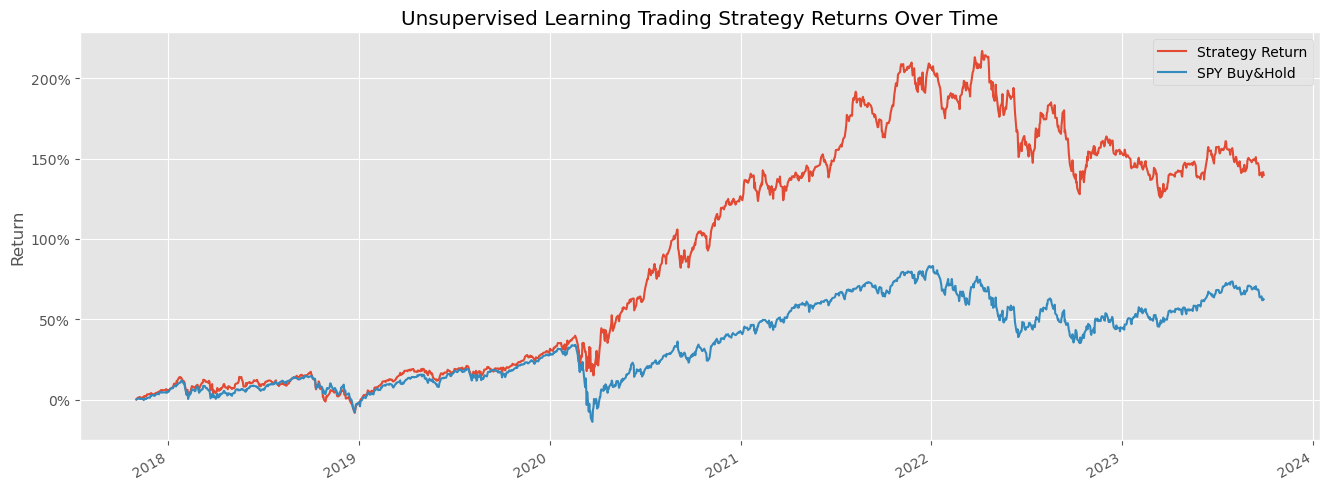

In [32]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


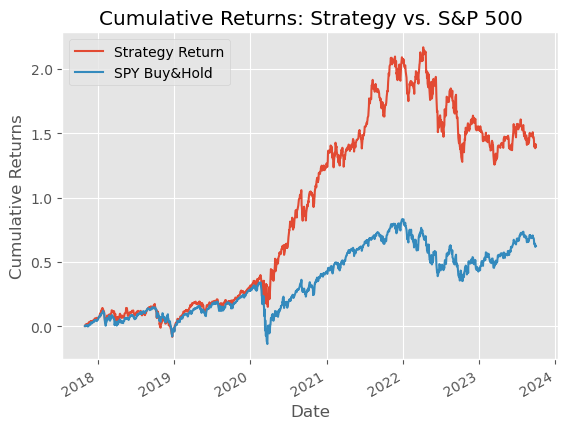

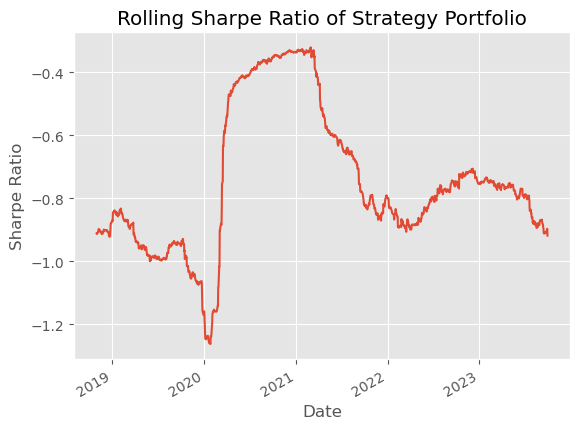

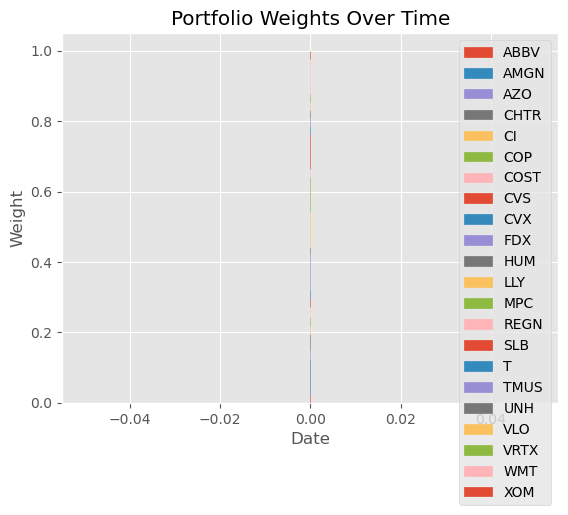

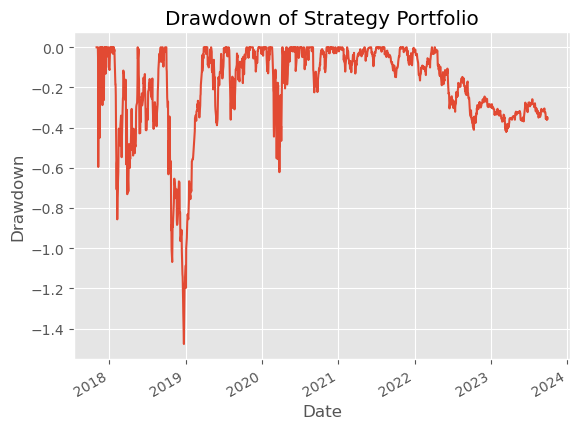

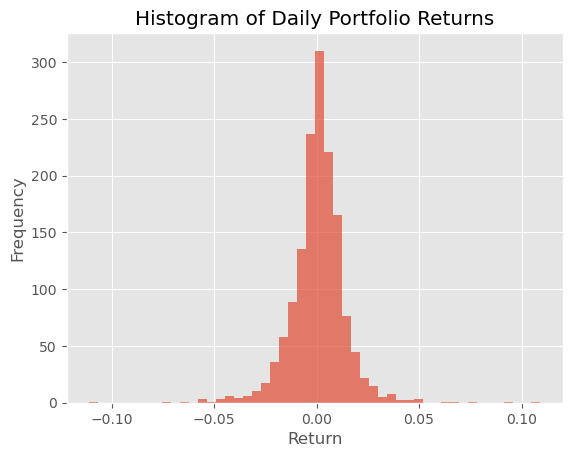

In [34]:
cumulative_returns = ((1 + portfolio_df[['Strategy Return', 'SPY Buy&Hold']]).cumprod() - 1)
cumulative_returns.plot(title='Cumulative Returns: Strategy vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()


risk_free_rate = 0.01  # Approximate risk-free rate
rolling_sharpe = (portfolio_df['Strategy Return'].rolling(window=252).mean() - risk_free_rate) / portfolio_df['Strategy Return'].rolling(window=252).std()
rolling_sharpe.plot(title='Rolling Sharpe Ratio of Strategy Portfolio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.show()


#Assuming weights are saved and have dates as index and tickers as columns
weights.plot.area(title='Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.show()


peak = cumulative_returns['Strategy Return'].cummax()
drawdown = (cumulative_returns['Strategy Return'] - peak) / peak
drawdown.plot(title='Drawdown of Strategy Portfolio')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()


portfolio_df['Strategy Return'].hist(bins=50, alpha=0.7)
plt.title('Histogram of Daily Portfolio Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()
